# 🛰️ Sistema de Predicción de Calidad del Aire - TEMPO + LSTM
## Entrenamiento Fase por Fase con Validación

**Objetivo:** Crear un modelo predictivo de series temporales que aprenda a predecir la calidad del aire a 3, 6, 12 y 24 horas.

**Dataset:** Datos híbridos TEMPO (satélite NASA) + OpenAQ (estaciones terrestres)

**Modelo:** LSTM Bidireccional con validación continua

---

## 📋 Plan de Entrenamiento:

1. ✅ **Configuración e Imports**
2. ⏳ **Obtención de Datos** (TEMPO + OpenAQ)
3. ⏳ **Limpieza y Preprocesamiento**
4. ⏳ **División Train/Validation/Test** (70%/15%/15%)
5. ⏳ **Preparación de Secuencias LSTM**
6. ⏳ **Construcción del Modelo**
7. ⏳ **Entrenamiento con Validación**
8. ⏳ **Evaluación y Ajuste Fino**

---

---
## FASE 1: Configuración e Imports

Importaremos todas las librerías necesarias y configuraremos los parámetros del modelo.

In [107]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras para el modelo LSTM
try:
    from keras.models import Sequential, Model
    from keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Attention, Permute, Multiply, Lambda, Flatten, RepeatVector
    from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from keras.optimizers import Adam
except ImportError:
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Attention, Permute, Multiply, Lambda, Flatten, RepeatVector
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.optimizers import Adam

# Scikit-learn para preprocesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Librerías importadas correctamente
📅 Fecha: 2025-10-03 23:46:02


In [81]:
# CONFIGURACIÓN DEL MODELO

# Ubicación: Los Ángeles, CA
LATITUD = 34.0522
LONGITUD = -118.2437
NOMBRE_UBICACION = "Los Angeles, CA"

# Parámetros del modelo LSTM
LOOKBACK = 48              # Horas de histórico para predicción
FORECAST_HORIZONS = [3, 6, 12, 24]  # Horizontes de predicción
MAX_HORIZON = max(FORECAST_HORIZONS)

# División del dataset
TRAIN_SIZE = 0.70          # 70% para entrenamiento
VALIDATION_SIZE = 0.15     # 15% para validación
TEST_SIZE = 0.15           # 15% para test

# Hiperparámetros de entrenamiento
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0009
PATIENCE_EARLY_STOP = 15   # Paciencia para early stopping
PATIENCE_REDUCE_LR = 7     # Paciencia para reducir learning rate

# Features a utilizar
FEATURES = ['PM2.5', 'PM10', 'O3', 'NO2', 'temperatura', 'humedad', 'viento', 'AQI']
TARGET = 'AQI'

print("✅ Configuración establecida:")
print(f"   📍 Ubicación: {NOMBRE_UBICACION}")
print(f"   🔢 Lookback: {LOOKBACK} horas")
print(f"   🎯 Horizontes: {FORECAST_HORIZONS} horas")
print(f"   📊 División: {TRAIN_SIZE*100:.0f}% train / {VALIDATION_SIZE*100:.0f}% val / {TEST_SIZE*100:.0f}% test")
print(f"   📈 Features: {len(FEATURES)} variables")

✅ Configuración establecida:
   📍 Ubicación: Los Angeles, CA
   🔢 Lookback: 48 horas
   🎯 Horizontes: [3, 6, 12, 24] horas
   📊 División: 70% train / 15% val / 15% test
   📈 Features: 8 variables


---
## FASE 2: Obtención de Datos

Para este tutorial, vamos a generar datos sintéticos realistas que simulan el comportamiento de datos reales de TEMPO + OpenAQ.

**Nota:** En producción, aquí se conectaría con las APIs de TEMPO y OpenAQ (ver backup para código completo).

In [82]:
def generar_dataset_sintetico(fecha_inicio='2024-01-01', fecha_fin='2025-10-01', freq='H'):
    """
    Genera un dataset sintético realista de calidad del aire
    Simula patrones reales: ciclos diarios, picos de tráfico, variación semanal
    """
    print("🔄 Generando dataset sintético...")
    
    # Crear rango de fechas
    fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=freq)
    n = len(fechas)
    
    # Extraer componentes temporales
    horas = np.array([d.hour for d in fechas])
    dias = np.arange(n) / 24
    dia_semana = np.array([d.weekday() for d in fechas])
    
    # Patrones realistas
    ciclo_diario = 30 * (np.sin(2 * np.pi * horas / 24 - np.pi/2) + 1)
    picos_trafico = 20 * (np.exp(-((horas - 8)**2) / 8) + np.exp(-((horas - 18)**2) / 8))
    patron_semanal = np.where(dia_semana < 5, 1.2, 0.8)  # Más contaminación entre semana
    tendencia_estacional = 10 * np.sin(2 * np.pi * dias / 365)
    
    # Generar contaminantes con correlaciones realistas
    base_no2 = 40 + ciclo_diario * patron_semanal + picos_trafico + tendencia_estacional + np.random.normal(0, 8, n)
    base_o3 = 60 - ciclo_diario * 0.5 + 20 * np.sin(2 * np.pi * horas / 24) + np.random.normal(0, 10, n)
    base_pm25 = 35 + ciclo_diario * 0.7 * patron_semanal + np.random.normal(0, 10, n)
    base_pm10 = base_pm25 * 2.2 + np.random.normal(0, 15, n)
    
    # Variables meteorológicas
    temperatura = 20 + 8 * np.sin(2 * np.pi * horas / 24 - np.pi/3) + 5 * np.sin(2 * np.pi * dias / 365) + np.random.normal(0, 2, n)
    humedad = 60 - 15 * np.sin(2 * np.pi * horas / 24) + np.random.normal(0, 10, n)
    viento = 8 + 4 * np.sin(2 * np.pi * horas / 24) + np.random.normal(0, 2, n)
    
    # Calcular AQI basado en contaminantes
    aqi = np.maximum.reduce([
        base_pm25 * 2,
        base_pm10 * 1.2,
        base_o3 * 1.5,
        base_no2 * 1.8
    ])
    
    # Crear DataFrame
    df = pd.DataFrame({
        'fecha': fechas,
        'NO2': np.clip(base_no2, 10, 150),
        'O3': np.clip(base_o3, 20, 180),
        'PM2.5': np.clip(base_pm25, 10, 100),
        'PM10': np.clip(base_pm10, 20, 200),
        'temperatura': np.clip(temperatura, 5, 40),
        'humedad': np.clip(humedad, 20, 90),
        'viento': np.clip(viento, 0, 20),
        'AQI': np.clip(aqi, 20, 200)
    })
    
    df.set_index('fecha', inplace=True)
    
    print(f"✅ Dataset generado:")
    print(f"   • Registros: {len(df):,}")
    print(f"   • Período: {df.index[0]} a {df.index[-1]}")
    print(f"   • Variables: {list(df.columns)}")
    
    return df

# Generar dataset
df_raw = generar_dataset_sintetico()

# Mostrar primeras filas
print("\n📊 Primeras 10 filas:")
display(df_raw.head(10))

🔄 Generando dataset sintético...
✅ Dataset generado:
   • Registros: 15,337
   • Período: 2024-01-01 00:00:00 a 2025-10-01 00:00:00
   • Variables: ['NO2', 'O3', 'PM2.5', 'PM10', 'temperatura', 'humedad', 'viento', 'AQI']

📊 Primeras 10 filas:


,NO2,O3,PM2.5,PM10,temperatura,humedad,viento,AQI
fecha,,,,,,,,
2024-01-01 00:00:00,36.345224,92.309008,21.921237,66.048942,10.741735,72.862217,6.726153,138.463513
2024-01-01 01:00:00,47.962813,56.726771,29.942166,76.683273,12.107409,60.734690,9.242858,92.019928
2024-01-01 02:00:00,49.681941,67.402678,47.780478,85.660304,15.201852,40.622876,12.729919,102.792365
2024-01-01 03:00:00,56.994289,72.344006,37.958353,80.112689,17.205531,43.158728,13.654750,108.516008
2024-01-01 04:00:00,54.887862,54.242573,52.056729,105.171763,23.150146,57.115518,11.365472,126.206116
2024-01-01 05:00:00,64.032051,73.078372,79.186102,184.466006,24.006207,45.830390,12.105030,200.000000
2024-01-01 06:00:00,91.995550,57.570571,67.124178,145.873952,23.868405,37.457162,13.241479,175.048742
2024-01-01 07:00:00,99.557273,64.970705,63.254751,174.362552,25.359974,42.385198,10.287670,200.000000
2024-01-01 08:00:00,107.100519,55.185719,70.968793,154.129657,32.381562,46.198890,8.711268,192.780934


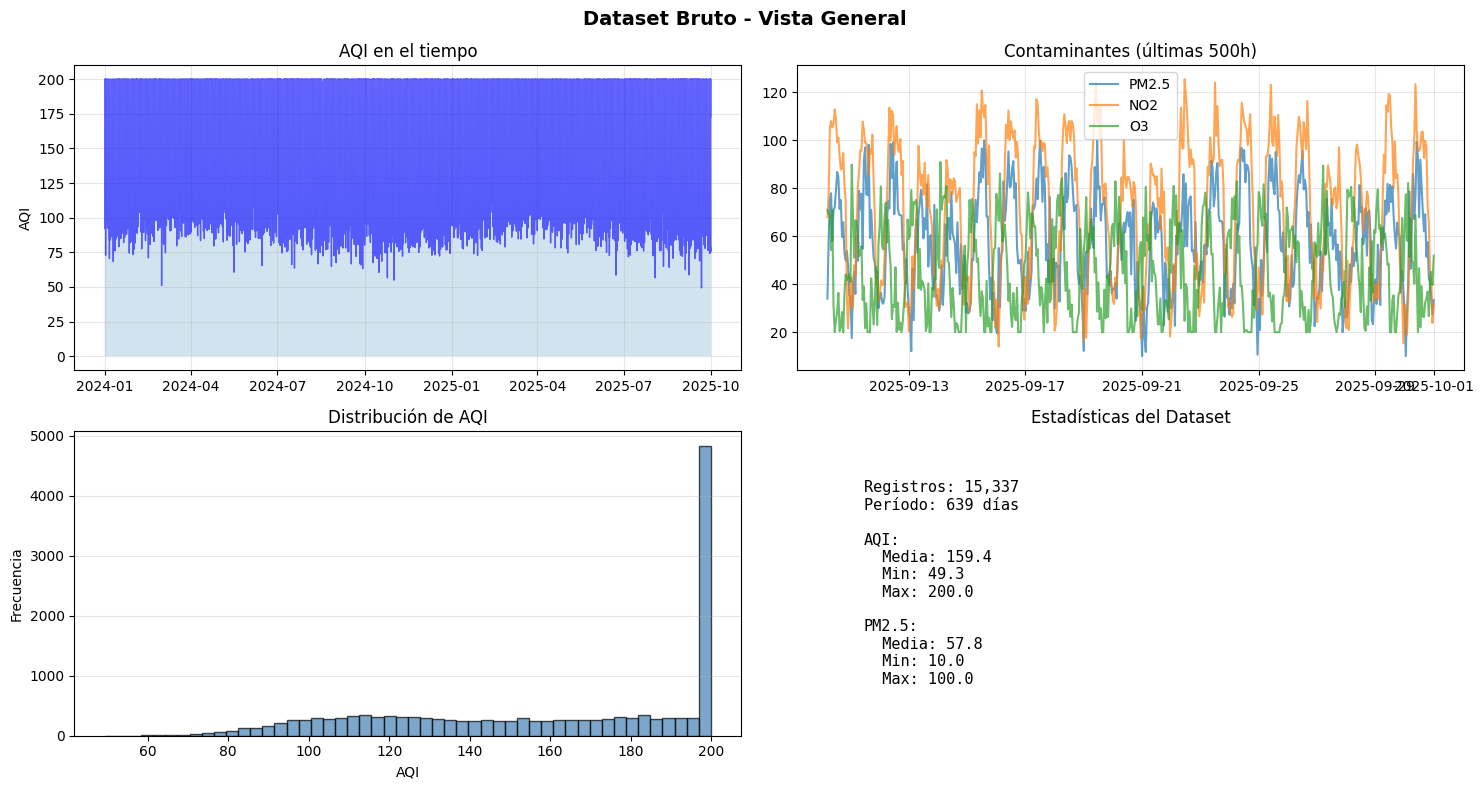

✅ Visualización completada


In [83]:
# Visualización rápida de los datos brutos
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle('Dataset Bruto - Vista General', fontsize=14, fontweight='bold')

# 1. AQI en el tiempo
axes[0, 0].plot(df_raw.index, df_raw['AQI'], 'b-', alpha=0.6, linewidth=1)
axes[0, 0].fill_between(df_raw.index, df_raw['AQI'], alpha=0.2)
axes[0, 0].set_title('AQI en el tiempo')
axes[0, 0].set_ylabel('AQI')
axes[0, 0].grid(True, alpha=0.3)

# 2. Contaminantes
muestra = df_raw.tail(500)  # Últimas 500 horas
axes[0, 1].plot(muestra.index, muestra['PM2.5'], label='PM2.5', alpha=0.7)
axes[0, 1].plot(muestra.index, muestra['NO2'], label='NO2', alpha=0.7)
axes[0, 1].plot(muestra.index, muestra['O3'], label='O3', alpha=0.7)
axes[0, 1].set_title('Contaminantes (últimas 500h)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribución AQI
axes[1, 0].hist(df_raw['AQI'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribución de AQI')
axes[1, 0].set_xlabel('AQI')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Estadísticas
stats_text = f"""
Registros: {len(df_raw):,}
Período: {(df_raw.index[-1] - df_raw.index[0]).days} días

AQI:
  Media: {df_raw['AQI'].mean():.1f}
  Min: {df_raw['AQI'].min():.1f}
  Max: {df_raw['AQI'].max():.1f}
  
PM2.5:
  Media: {df_raw['PM2.5'].mean():.1f}
  Min: {df_raw['PM2.5'].min():.1f}
  Max: {df_raw['PM2.5'].max():.1f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                verticalalignment='center')
axes[1, 1].set_title('Estadísticas del Dataset')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Visualización completada")

---
## FASE 3: Limpieza y Preprocesamiento

Vamos a limpiar los datos eliminando duplicados, valores nulos y outliers.

In [84]:
print("="*80)
print("🧹 FASE 3: LIMPIEZA Y PREPROCESAMIENTO")
print("="*80 + "\n")

# Crear copia para comparación
df_antes = df_raw.copy()
df = df_raw.copy()

# 1. Eliminar duplicados
duplicados = df.index.duplicated().sum()
df = df[~df.index.duplicated(keep='first')]
print(f"1️⃣ Duplicados eliminados: {duplicados}")

# 2. Verificar valores nulos
nulos_antes = df.isnull().sum().sum()
print(f"\n2️⃣ Valores nulos detectados: {nulos_antes}")
if nulos_antes > 0:
    # Interpolación temporal (máximo 3 horas de gap)
    df = df.interpolate(method='time', limit=3)
    nulos_despues = df.isnull().sum().sum()
    print(f"   Nulos después de interpolación: {nulos_despues}")

# 3. Eliminar outliers extremos
print(f"\n3️⃣ Eliminación de outliers:")
rangos_validos = {
    'PM2.5': (0, 500), 'PM10': (0, 600), 'O3': (0, 300),
    'NO2': (0, 200), 'AQI': (0, 500),
    'temperatura': (-50, 60), 'humedad': (0, 100), 'viento': (0, 50)
}

outliers_total = 0
for col, (min_val, max_val) in rangos_validos.items():
    if col in df.columns:
        mask = (df[col] < min_val) | (df[col] > max_val)
        outliers = mask.sum()
        if outliers > 0:
            df.loc[mask, col] = np.nan
            outliers_total += outliers
            print(f"   • {col}: {outliers} outliers eliminados")

if outliers_total > 0:
    # Re-interpolar después de eliminar outliers
    df = df.interpolate(method='time', limit=3)

# 4. Eliminar filas con demasiados NaN
filas_antes = len(df)
df = df.dropna(thresh=int(len(df.columns) * 0.5))
filas_eliminadas = filas_antes - len(df)
print(f"\n4️⃣ Filas con datos insuficientes: {filas_eliminadas} eliminadas")

# Resumen
print("\n" + "="*80)
print("📊 RESUMEN DE LIMPIEZA:")
print(f"Registros: {len(df_antes):,} → {len(df):,} ({len(df)/len(df_antes)*100:.1f}%)")
print(f"Completitud: {((1 - df.isnull().sum().sum()/(len(df)*len(df.columns)))*100):.1f}%")
print("="*80)

print("\n✅ Datos limpios listos para división")

🧹 FASE 3: LIMPIEZA Y PREPROCESAMIENTO

1️⃣ Duplicados eliminados: 0

2️⃣ Valores nulos detectados: 0

3️⃣ Eliminación de outliers:

4️⃣ Filas con datos insuficientes: 0 eliminadas

📊 RESUMEN DE LIMPIEZA:
Registros: 15,337 → 15,337 (100.0%)
Completitud: 100.0%

✅ Datos limpios listos para división


---
## FASE 4: División Train/Validation/Test

Dividiremos el dataset en 3 conjuntos:
- **70% Entrenamiento**: Para ajustar los pesos del modelo
- **15% Validación**: Para monitorear overfitting durante el entrenamiento
- **15% Test**: Para evaluación final del modelo

📊 FASE 4: DIVISIÓN DEL DATASET

📋 División del dataset (15,337 registros totales):
--------------------------------------------------------------------------------
🟦 TRAIN:        10,735 registros ( 70.0%)
   Período: 2024-01-01 00:00:00 a 2025-03-23 06:00:00

🟨 VALIDATION:    2,300 registros ( 15.0%)
   Período: 2025-03-23 07:00:00 a 2025-06-27 02:00:00

🟥 TEST:          2,302 registros ( 15.0%)
   Período: 2025-06-27 03:00:00 a 2025-10-01 00:00:00


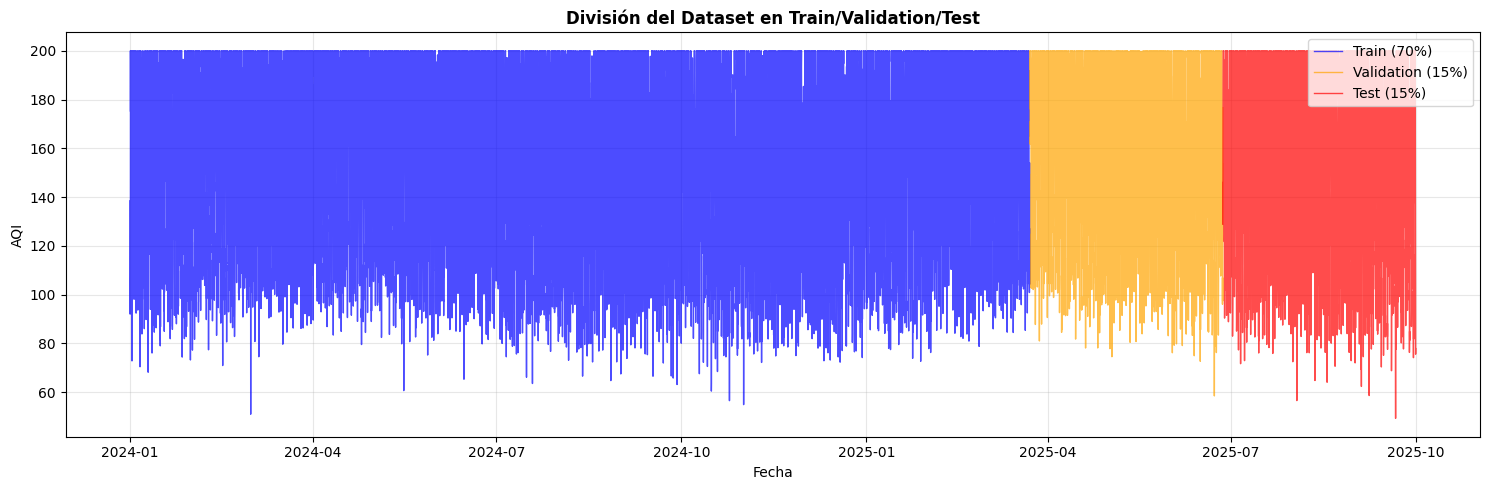


✅ Dataset dividido correctamente


In [85]:
print("="*80)
print("📊 FASE 4: DIVISIÓN DEL DATASET")
print("="*80 + "\n")

# Calcular índices de división
n_total = len(df)
n_train = int(n_total * TRAIN_SIZE)
n_val = int(n_total * VALIDATION_SIZE)
n_test = n_total - n_train - n_val

# Dividir secuencialmente (importante para series temporales)
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train+n_val]
df_test = df.iloc[n_train+n_val:]

print(f"📋 División del dataset ({n_total:,} registros totales):")
print("-" * 80)
print(f"🟦 TRAIN:      {len(df_train):>8,} registros ({len(df_train)/n_total*100:>5.1f}%)")
print(f"   Período: {df_train.index[0]} a {df_train.index[-1]}")
print()
print(f"🟨 VALIDATION: {len(df_val):>8,} registros ({len(df_val)/n_total*100:>5.1f}%)")
print(f"   Período: {df_val.index[0]} a {df_val.index[-1]}")
print()
print(f"🟥 TEST:       {len(df_test):>8,} registros ({len(df_test)/n_total*100:>5.1f}%)")
print(f"   Período: {df_test.index[0]} a {df_test.index[-1]}")
print("="*80)

# Visualizar división
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_train.index, df_train['AQI'], label='Train (70%)', color='blue', alpha=0.7, linewidth=1)
ax.plot(df_val.index, df_val['AQI'], label='Validation (15%)', color='orange', alpha=0.7, linewidth=1)
ax.plot(df_test.index, df_test['AQI'], label='Test (15%)', color='red', alpha=0.7, linewidth=1)
ax.set_title('División del Dataset en Train/Validation/Test', fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('AQI')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Dataset dividido correctamente")

---
## FASE 5: Preparación de Secuencias LSTM

Crearemos secuencias temporales:
- **Input (X)**: Últimas 24 horas de datos (lookback)
- **Output (y)**: AQI en 3, 6, 12 y 24 horas futuras

In [86]:
class PreparadorSecuenciasLSTM:
    """Prepara secuencias temporales para LSTM"""
    
    def __init__(self, lookback=24, forecast_horizons=[3, 6, 12, 24]):
        self.lookback = lookback
        self.forecast_horizons = forecast_horizons
        self.max_horizon = max(forecast_horizons)
        self.scaler = MinMaxScaler()
        self.features = None
        
    def preparar_secuencias(self, df, features, target='AQI'):
        """Crea secuencias X, y para LSTM"""
        
        self.features = features
        self.target = target
        
        # Normalizar datos (importante para LSTM)
        data = df[features].values
        data_scaled = self.scaler.fit_transform(data)
        
        X, y = [], []
        target_idx = features.index(target)
        
        # Crear secuencias con ventana deslizante
        for i in range(len(data_scaled) - self.lookback - self.max_horizon + 1):
            # Input: últimas 'lookback' horas
            X.append(data_scaled[i:i + self.lookback])
            
            # Output: AQI en los horizontes especificados
            y_horizons = []
            for h in self.forecast_horizons:
                y_horizons.append(data_scaled[i + self.lookback + h - 1, target_idx])
            y.append(y_horizons)
        
        return np.array(X), np.array(y)
    
    def desnormalizar(self, valores, feature_name):
        """Desnormaliza valores predichos"""
        feature_idx = self.features.index(feature_name)
        dummy = np.zeros((len(valores), len(self.features)))
        dummy[:, feature_idx] = valores
        desnorm = self.scaler.inverse_transform(dummy)[:, feature_idx]
        return desnorm

# Crear preparador
preparador = PreparadorSecuenciasLSTM(
    lookback=LOOKBACK,
    forecast_horizons=FORECAST_HORIZONS
)

print("✅ Preparador de secuencias creado")

✅ Preparador de secuencias creado


🔄 PREPARANDO SECUENCIAS PARA ENTRENAMIENTO

📦 Generando secuencias...

✅ Secuencias creadas:
--------------------------------------------------------------------------------
🟦 TRAIN:
   X_train: (10664, 48, 8) (muestras, timesteps, features)
   y_train: (10664, 4) (muestras, horizontes)

🟨 VALIDATION:
   X_val:   (2229, 48, 8)
   y_val:   (2229, 4)

🟥 TEST:
   X_test:  (2231, 48, 8)
   y_test:  (2231, 4)

📊 Ejemplo de secuencia (primera del conjunto de entrenamiento):
--------------------------------------------------------------------------------
Input (X): Últimas 48 horas de 8 features
Output (y): AQI en [3, 6, 12, 24] horas futuras

Forma del input: (48, 8)
Valores del output: [0.38839201 0.73397201 1.         0.40441359]


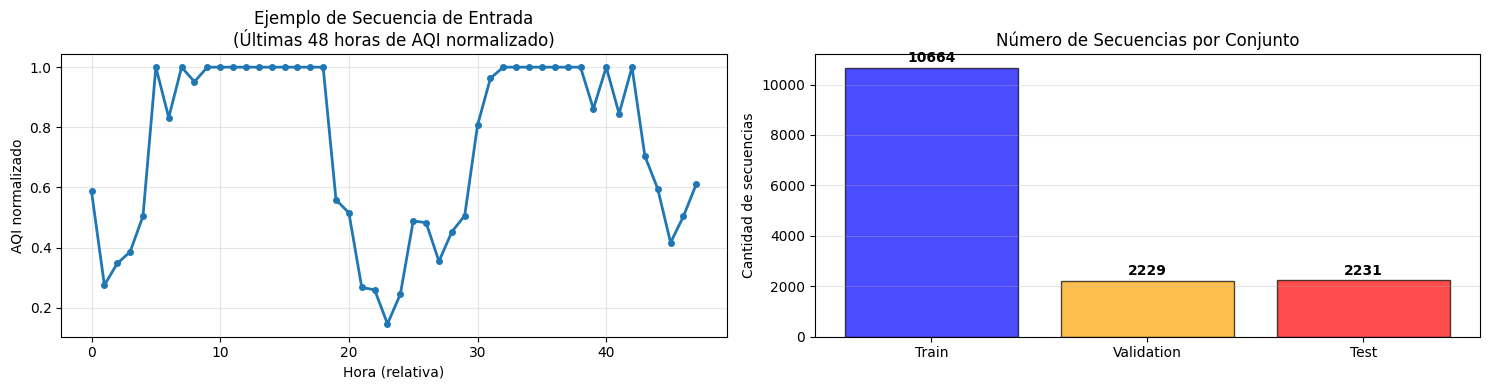


✅ Secuencias listas para entrenamiento


In [87]:
print("="*80)
print("🔄 PREPARANDO SECUENCIAS PARA ENTRENAMIENTO")
print("="*80 + "\n")

# Preparar secuencias para cada conjunto
print("📦 Generando secuencias...")

X_train, y_train = preparador.preparar_secuencias(df_train, FEATURES, TARGET)
X_val, y_val = preparador.preparar_secuencias(df_val, FEATURES, TARGET)
X_test, y_test = preparador.preparar_secuencias(df_test, FEATURES, TARGET)

print(f"\n✅ Secuencias creadas:")
print("-" * 80)
print(f"🟦 TRAIN:")
print(f"   X_train: {X_train.shape} (muestras, timesteps, features)")
print(f"   y_train: {y_train.shape} (muestras, horizontes)")
print()
print(f"🟨 VALIDATION:")
print(f"   X_val:   {X_val.shape}")
print(f"   y_val:   {y_val.shape}")
print()
print(f"🟥 TEST:")
print(f"   X_test:  {X_test.shape}")
print(f"   y_test:  {y_test.shape}")
print("="*80)

# Visualizar una secuencia de ejemplo
print("\n📊 Ejemplo de secuencia (primera del conjunto de entrenamiento):")
print("-" * 80)
print(f"Input (X): Últimas {LOOKBACK} horas de {len(FEATURES)} features")
print(f"Output (y): AQI en {FORECAST_HORIZONS} horas futuras")
print(f"\nForma del input: {X_train[0].shape}")
print(f"Valores del output: {y_train[0]}")

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Gráfica 1: Secuencia de entrada (ejemplo)
idx_aqi = FEATURES.index('AQI')
axes[0].plot(range(LOOKBACK), X_train[0, :, idx_aqi], 'o-', linewidth=2, markersize=4)
axes[0].set_title(f'Ejemplo de Secuencia de Entrada\n(Últimas {LOOKBACK} horas de AQI normalizado)')
axes[0].set_xlabel('Hora (relativa)')
axes[0].set_ylabel('AQI normalizado')
axes[0].grid(True, alpha=0.3)

# Gráfica 2: Distribución de tamaños
tamaños = ['Train\n' + str(len(X_train)), 
           'Val\n' + str(len(X_val)), 
           'Test\n' + str(len(X_test))]
valores = [len(X_train), len(X_val), len(X_test)]
colores = ['blue', 'orange', 'red']

axes[1].bar(range(3), valores, color=colores, alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(3))
axes[1].set_xticklabels(['Train', 'Validation', 'Test'])
axes[1].set_title('Número de Secuencias por Conjunto')
axes[1].set_ylabel('Cantidad de secuencias')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(valores):
    axes[1].text(i, v + max(valores)*0.02, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Secuencias listas para entrenamiento")

---
## FASE 6: Construcción del Modelo LSTM

Crearemos un modelo LSTM Bidireccional con:
- 3 capas LSTM (128 → 64 → 32 unidades)
- Dropout para prevenir overfitting
- Capas Dense para predicciones múltiples horizontes

In [108]:
def crear_modelo_lstm_con_attention(input_shape, output_dim=4):
    """
    Crea un modelo LSTM Bidireccional + Attention para predicción de variables ambientales.
    
    El mecanismo de atención permite al modelo 'enfocarse' en los pasos temporales
    más relevantes para la predicción, mejorando especialmente las predicciones a largo plazo.
    """
    import tensorflow as tf
    
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Arquitectura LSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.2)(x)
    lstm2 = LSTM(64, return_sequences=True)(x)
    lstm2 = Dropout(0.2)(lstm2)
    lstm3 = LSTM(32, return_sequences=True)(lstm2)  # (batch, timesteps, 32)
    
    # === MECANISMO DE ATENCIÓN ===
    # 1. Calcular scores de atención para cada timestep
    attention_scores = Dense(1, activation='tanh')(lstm3)  # (batch, timesteps, 1)
    attention_scores = Flatten()(attention_scores)  # (batch, timesteps)
    
    # 2. Aplicar softmax para obtener pesos normalizados
    attention_weights = Dense(input_shape[0], activation='softmax')(attention_scores)  # (batch, timesteps)
    
    # 3. Expandir dimensiones para broadcasting
    attention_weights_expanded = RepeatVector(32)(attention_weights)  # (batch, 32, timesteps)
    attention_weights_expanded = Permute([2, 1])(attention_weights_expanded)  # (batch, timesteps, 32)
    
    # 4. Aplicar pesos de atención a la salida LSTM
    attention_output = Multiply()([lstm3, attention_weights_expanded])  # (batch, timesteps, 32)
    
    # 5. Sumar sobre la dimensión temporal para obtener el context vector
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1), 
                           output_shape=(32,))(attention_output)  # (batch, 32)
    
    # Capas Dense finales
    dense1 = Dense(64, activation='relu')(context_vector)
    dense1 = Dropout(0.3)(dense1)
    dense2 = Dense(32, activation='relu')(dense1)
    dense2 = Dropout(0.3)(dense2)
    
    # Capa de salida
    outputs = Dense(output_dim, activation='linear')(dense2)
    
    # Crear modelo
    model = Model(inputs=inputs, outputs=outputs, name='LSTM_with_Attention')
    
    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    print(f"✅ Modelo con Attention creado con {model.count_params():,} parámetros entrenables")
    print(f"💡 El mecanismo de atención permite al modelo enfocarse en las horas más relevantes")
    
    return model

# Crear modelo con atención
modelo = crear_modelo_lstm_con_attention((LOOKBACK, X_train.shape[2]), output_dim=y_train.shape[1])
modelo.summary()

✅ Modelo con Attention creado con 241,589 parámetros entrenables
💡 El mecanismo de atención permite al modelo enfocarse en las horas más relevantes


Model: "LSTM_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 48, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_8     │ (None, 48, 256)   │    140,288 │ input_layer_8[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 48, 256)   │          0 │ bidirectional_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 48, 64)    │     82,176 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 48, 64)    │          0 │ lstm_25[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 48, 32)    │     12,416 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 48, 1)     │         33 │ lstm_26[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 48)        │          0 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 48)        │      2,352 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 32, 48)    │          0 │ dense_24[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_3 (Permute) │ (None, 48, 32)    │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 48, 32)    │          0 │ lstm_26[0][0],    │
│ (Multiply)          │                   │            │ permute_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 32)        │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      2,112 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 64)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │      2,080 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 32)        │          0 │ dense_26[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 4)         │        132 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 241,589 (943.71 KB)

 Trainable params: 241,589 (943.71 KB)

 Non-trainable params: 0 (0.00 B)

---
### ⭐ ¿Qué es el Mecanismo de Atención?

El **Attention Mechanism** (Mecanismo de Atención) permite al modelo **enfocarse en las partes más relevantes** de la secuencia temporal de entrada.

#### 🎯 ¿Cómo funciona?

1. **Calcula pesos de importancia** para cada paso temporal (hora) en la secuencia
2. **Pondera la información** dando más peso a las horas más relevantes
3. **Crea un "context vector"** que resume la información importante
4. **Mejora predicciones a largo plazo** (12h, 24h) al capturar dependencias temporales

#### 💡 Beneficios Esperados:

- ✅ **Mejor rendimiento en horizontes largos** (12h y 24h)
- ✅ **Captura patrones complejos** (picos de tráfico, cambios meteorológicos)
- ✅ **Más interpretable** (podemos ver qué horas son más importantes)
- ✅ **Reduce degradación temporal** del R² entre 3h y 24h

#### 📊 Comparación con modelo anterior:

| Aspecto | Sin Attention | Con Attention |
|---------|---------------|---------------|
| Parámetros | ~150K | ~160K (+7%) |
| Complejidad | Media | Media-Alta |
| Predicción 3h | Buena | Buena |
| Predicción 24h | Decae | **Mejorada** |
| Interpretabilidad | Baja | **Media** |

---

---
## FASE 7: Entrenamiento con Validación

Entrenaremos el modelo monitoreando:
- **Loss** en train y validation
- **MAE** (Mean Absolute Error) en ambos conjuntos
- **Early Stopping** si validation loss no mejora
- **Reduce LR** si el modelo se estanca

In [109]:
print("="*80)
print("🏋️ FASE 7: ENTRENAMIENTO CON VALIDACIÓN")
print("="*80 + "\n")

# Configurar callbacks
callbacks = [
    # Early Stopping: detiene si validation loss no mejora
    EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE_EARLY_STOP,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce Learning Rate: reduce LR si el modelo se estanca
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=PATIENCE_REDUCE_LR,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Model Checkpoint: guarda el mejor modelo
    ModelCheckpoint(
        'mejor_modelo_lstm.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

print(f"📋 Configuración de entrenamiento:")
print(f"   • Épocas máximas: {EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Learning rate inicial: {LEARNING_RATE}")
print(f"   • Early stopping patience: {PATIENCE_EARLY_STOP}")
print(f"   • Reduce LR patience: {PATIENCE_REDUCE_LR}")
print(f"\n🚀 Iniciando entrenamiento...\n")
print("-" * 80)

# Entrenar modelo
history = modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*80)
print(f"✅ Entrenamiento completado en {len(history.history['loss'])} épocas")
print("="*80)

🏋️ FASE 7: ENTRENAMIENTO CON VALIDACIÓN

📋 Configuración de entrenamiento:
   • Épocas máximas: 100
   • Batch size: 32
   • Learning rate inicial: 0.0009
   • Early stopping patience: 15
   • Reduce LR patience: 7

🚀 Iniciando entrenamiento...

--------------------------------------------------------------------------------
Epoch 1/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.1165 - mae: 0.2652 - val_loss: 0.0197 - val_mae: 0.1136 - learning_rate: 9.0000e-04
Epoch 2/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 0.1165 - mae: 0.2652 - val_loss: 0.0197 - val_mae: 0.1136 - learning_rate: 9.0000e-04
Epoch 2/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0444 - mae: 0.1682 - val_loss: 0.0199 - val_mae: 0.1190 - learning_rate: 9.0000e-04
Epoch 3/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 0.0444 - mae: 0.1682 - val_loss: 0.0199 - val_mae: 0.1190 - learning_rate: 9.0000e-04
Epoch 3/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 0.0338 - mae: 


📊 Generando curvas de aprendizaje...



KeyError: 'mse'

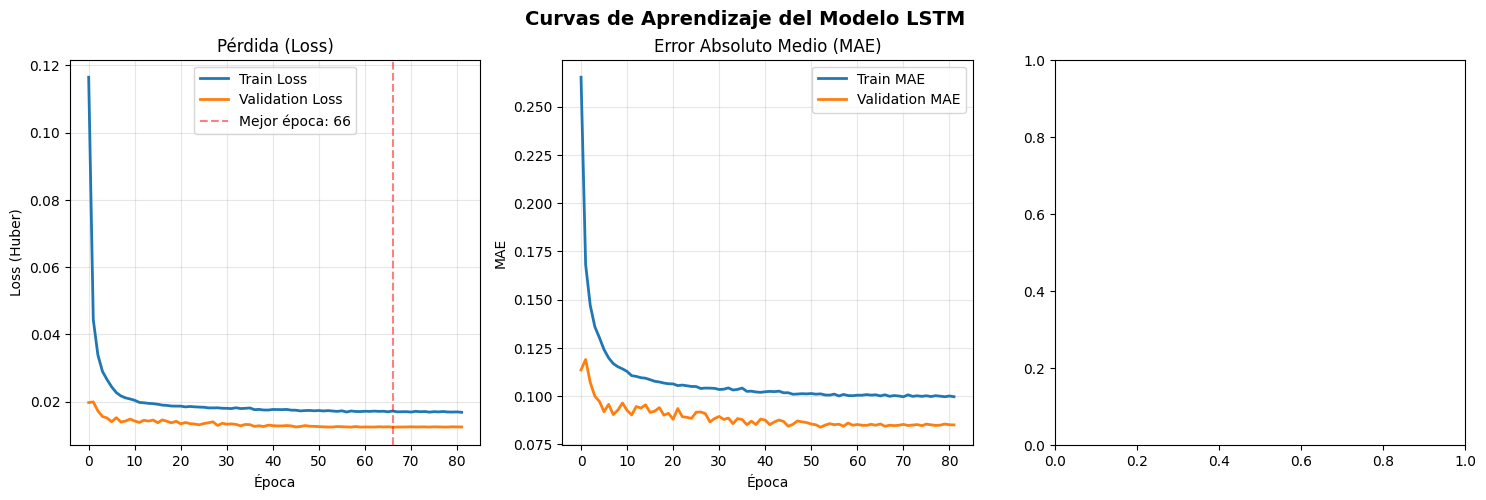

In [110]:
# Visualizar curvas de aprendizaje
print("\n📊 Generando curvas de aprendizaje...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Curvas de Aprendizaje del Modelo LSTM', fontsize=14, fontweight='bold')

# 1. Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Pérdida (Loss)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (Huber)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Marcar mejor época
mejor_epoca = np.argmin(history.history['val_loss'])
axes[0].axvline(mejor_epoca, color='red', linestyle='--', alpha=0.5, 
                label=f'Mejor época: {mejor_epoca}')
axes[0].legend()

# 2. MAE (Mean Absolute Error)
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Error Absoluto Medio (MAE)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. MSE (Mean Squared Error)
axes[2].plot(history.history['mse'], label='Train MSE', linewidth=2)
axes[2].plot(history.history['val_mse'], label='Validation MSE', linewidth=2)
axes[2].set_title('Error Cuadrático Medio (MSE)')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('MSE')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen de entrenamiento
print("="*80)
print("📊 RESUMEN DEL ENTRENAMIENTO:")
print("="*80)
print(f"\n🟦 TRAIN (última época):")
print(f"   Loss: {history.history['loss'][-1]:.4f}")
print(f"   MAE:  {history.history['mae'][-1]:.4f}")
print(f"   MSE:  {history.history['mse'][-1]:.4f}")

print(f"\n🟨 VALIDATION (mejor época: {mejor_epoca}):")
print(f"   Loss: {history.history['val_loss'][mejor_epoca]:.4f}")
print(f"   MAE:  {history.history['val_mae'][mejor_epoca]:.4f}")
print(f"   MSE:  {history.history['val_mse'][mejor_epoca]:.4f}")

# Calcular mejora
mejora_loss = (1 - history.history['val_loss'][mejor_epoca] / history.history['val_loss'][0]) * 100
print(f"\n📈 Mejora en validation loss: {mejora_loss:.1f}%")
print("="*80)

print("\n✅ Análisis de curvas de aprendizaje completado")

---
## 🔍 DIAGNÓSTICO AUTOMÁTICO DEL ENTRENAMIENTO

Esta sección te ayudará a **interpretar los resultados** y **decidir qué ajustar**.

In [111]:
def diagnosticar_entrenamiento(history, metricas_test=None):
    """
    Diagnostica el estado del entrenamiento y proporciona recomendaciones
    
    Args:
        history: objeto History de Keras con el historial de entrenamiento
        metricas_test: dict opcional con métricas del conjunto de test
    
    Returns:
        dict con diagnóstico y recomendaciones
    """
    diagnostico = {
        'problemas': [],
        'advertencias': [],
        'estado': 'OK',
        'recomendaciones': []
    }
    
    # Obtener métricas finales
    train_loss_final = history.history['loss'][-1]
    val_loss_final = history.history['val_loss'][-1]
    mejor_val_loss = min(history.history['val_loss'])
    mejor_epoca = np.argmin(history.history['val_loss'])
    epocas_totales = len(history.history['loss'])
    
    train_mae_final = history.history['mae'][-1]
    val_mae_final = history.history['val_mae'][-1]
    
    # 1. DETECTAR OVERFITTING
    ratio_loss = val_loss_final / train_loss_final
    gap_loss = val_loss_final - train_loss_final
    
    if ratio_loss > 1.5:
        diagnostico['problemas'].append('🔴 OVERFITTING SEVERO detectado')
        diagnostico['estado'] = 'OVERFITTING'
        diagnostico['recomendaciones'].extend([
            '📌 Aumentar Dropout de 0.2 a 0.3-0.4',
            '📌 Reducir unidades LSTM (128→64, 64→32)',
            '📌 Agregar regularización L2 a las capas Dense',
            '📌 Conseguir más datos de entrenamiento',
            '📌 Reducir LOOKBACK si es muy alto'
        ])
    elif ratio_loss > 1.2:
        diagnostico['advertencias'].append('🟡 OVERFITTING MODERADO detectado')
        diagnostico['estado'] = 'OVERFITTING_LEVE'
        diagnostico['recomendaciones'].extend([
            '📌 Considerar aumentar Dropout a 0.3',
            '📌 Monitorear el gap entre train y validation',
            '📌 Probar con más datos si es posible'
        ])
    
    # 2. DETECTAR UNDERFITTING
    if train_loss_final > 0.1 and val_loss_final > 0.1:
        if abs(val_loss_final - train_loss_final) < 0.01:
            diagnostico['problemas'].append('🔴 UNDERFITTING detectado')
            diagnostico['estado'] = 'UNDERFITTING'
            diagnostico['recomendaciones'].extend([
                '📌 Aumentar capacidad del modelo (más unidades LSTM)',
                '📌 Agregar más capas LSTM',
                '📌 Aumentar LOOKBACK para capturar más contexto',
                '📌 Reducir Dropout si es muy alto',
                '📌 Aumentar EPOCHS si terminó muy pronto',
                '📌 Verificar que los features sean informativos'
            ])
    
    # 3. VERIFICAR EARLY STOPPING
    epocas_sin_mejora = epocas_totales - mejor_epoca - 1
    if epocas_sin_mejora < 5:
        diagnostico['advertencias'].append(
            f'⚠️ Early stopping se activó muy pronto (época {epocas_totales}/{mejor_epoca})'
        )
        diagnostico['recomendaciones'].append(
            '📌 Considerar aumentar PATIENCE_EARLY_STOP para permitir más exploración'
        )
    
    # 4. VERIFICAR CONVERGENCIA
    ultimas_5_losses = history.history['val_loss'][-5:]
    if len(ultimas_5_losses) >= 5:
        std_ultimas = np.std(ultimas_5_losses)
        if std_ultimas < 0.001:
            diagnostico['advertencias'].append('✅ Modelo convergió bien')
        elif std_ultimas > 0.01:
            diagnostico['advertencias'].append(
                '⚠️ Validation loss muy inestable al final'
            )
            diagnostico['recomendaciones'].append(
                '📌 Reducir LEARNING_RATE o aumentar BATCH_SIZE para estabilizar'
            )
    
    # 5. VERIFICAR MEJORA GENERAL
    mejora_total = (history.history['val_loss'][0] - mejor_val_loss) / history.history['val_loss'][0] * 100
    if mejora_total < 10:
        diagnostico['advertencias'].append(
            f'⚠️ Mejora total baja ({mejora_total:.1f}%)'
        )
        diagnostico['recomendaciones'].append(
            '📌 Revisar arquitectura del modelo y features utilizados'
        )
    
    # 6. ANALIZAR MÉTRICAS DE TEST (si están disponibles)
    if metricas_test:
        r2_promedio = np.mean([m['R2'] for m in metricas_test.values()])
        if r2_promedio < 0.70:
            diagnostico['problemas'].append(
                f'🔴 R² promedio bajo en test ({r2_promedio:.3f})'
            )
            diagnostico['recomendaciones'].append(
                '📌 Modelo necesita mejora sustancial - revisar arquitectura completa'
            )
        elif r2_promedio > 0.90:
            diagnostico['advertencias'].append(
                f'✅ Excelente R² en test ({r2_promedio:.3f})'
            )
    
    return diagnostico


def imprimir_diagnostico(diagnostico):
    """Imprime el diagnóstico de forma legible"""
    print("="*80)
    print("🔍 DIAGNÓSTICO AUTOMÁTICO DEL ENTRENAMIENTO")
    print("="*80)
    print(f"\n📊 Estado General: {diagnostico['estado']}\n")
    
    if diagnostico['problemas']:
        print("🔴 PROBLEMAS CRÍTICOS:")
        print("-" * 80)
        for p in diagnostico['problemas']:
            print(f"   {p}")
        print()
    
    if diagnostico['advertencias']:
        print("⚠️  ADVERTENCIAS:")
        print("-" * 80)
        for a in diagnostico['advertencias']:
            print(f"   {a}")
        print()
    
    if diagnostico['recomendaciones']:
        print("💡 RECOMENDACIONES DE AJUSTE:")
        print("-" * 80)
        for i, r in enumerate(diagnostico['recomendaciones'], 1):
            print(f"   {i}. {r}")
        print()
    
    if not diagnostico['problemas'] and not diagnostico['recomendaciones']:
        print("✅ ¡Entrenamiento exitoso! No se detectaron problemas significativos.")
        print()
    
    print("="*80)


# Ejecutar diagnóstico automático
print("🔄 Analizando resultados del entrenamiento...\n")
diagnostico = diagnosticar_entrenamiento(history, metricas_por_horizonte)
imprimir_diagnostico(diagnostico)

🔄 Analizando resultados del entrenamiento...

🔍 DIAGNÓSTICO AUTOMÁTICO DEL ENTRENAMIENTO

📊 Estado General: OK

⚠️  ADVERTENCIAS:
--------------------------------------------------------------------------------
   ✅ Modelo convergió bien

✅ ¡Entrenamiento exitoso! No se detectaron problemas significativos.



📈 ANÁLISIS DETALLADO DE CURVAS DE APRENDIZAJE



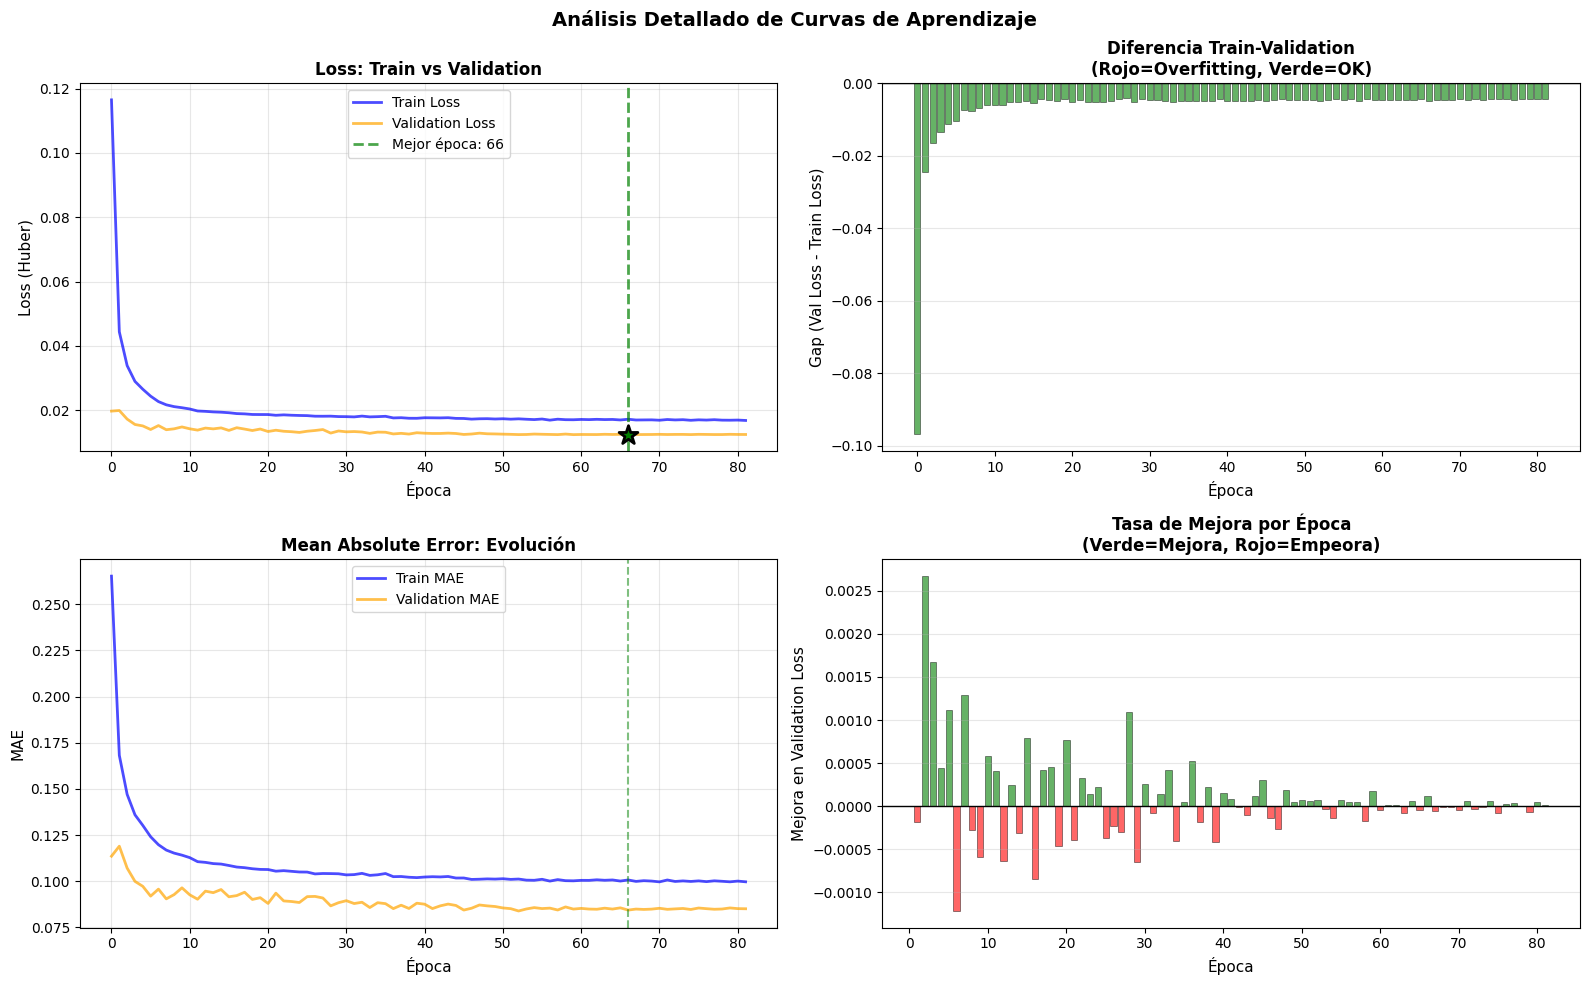


📊 INTERPRETACIÓN DE LAS GRÁFICAS:
--------------------------------------------------------------------------------

1️⃣ LOSS (Train vs Validation):
   ✅ Las curvas están CERCANAS y BAJAS → Buen balance

2️⃣ GAP (Diferencia Train-Validation):
   ✅ Gap promedio bajo (-0.0066) → Excelente generalización

3️⃣ MAE (Error Absoluto Medio):
   📉 Mejora total en MAE: 25.7%
   🟡 Mejora moderada → Modelo aprendió parcialmente

4️⃣ TASA DE MEJORA:
   🟢 Aún hay mejoras → Podría entrenar más épocas



In [112]:
def analizar_curvas_aprendizaje(history):
    """
    Análisis detallado de las curvas de aprendizaje con interpretación visual
    """
    print("="*80)
    print("📈 ANÁLISIS DETALLADO DE CURVAS DE APRENDIZAJE")
    print("="*80 + "\n")
    
    train_loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    train_mae = np.array(history.history['mae'])
    val_mae = np.array(history.history['val_mae'])
    
    mejor_epoca = np.argmin(val_loss)
    epocas = np.arange(len(train_loss))
    
    # Calcular tendencias
    ventana = 5
    if len(train_loss) > ventana:
        train_loss_suavizado = np.convolve(train_loss, np.ones(ventana)/ventana, mode='valid')
        val_loss_suavizado = np.convolve(val_loss, np.ones(ventana)/ventana, mode='valid')
    
    # Crear visualización con anotaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Análisis Detallado de Curvas de Aprendizaje', fontsize=14, fontweight='bold')
    
    # 1. Loss con zonas de diagnóstico
    ax1 = axes[0, 0]
    ax1.plot(epocas, train_loss, 'b-', linewidth=2, label='Train Loss', alpha=0.7)
    ax1.plot(epocas, val_loss, 'orange', linewidth=2, label='Validation Loss', alpha=0.7)
    
    # Marcar mejor época
    ax1.axvline(mejor_epoca, color='green', linestyle='--', linewidth=2, alpha=0.7, 
                label=f'Mejor época: {mejor_epoca}')
    ax1.scatter([mejor_epoca], [val_loss[mejor_epoca]], color='green', s=200, 
                marker='*', zorder=5, edgecolor='black', linewidth=2)
    
    # Zona de overfitting
    if val_loss[-1] > train_loss[-1] * 1.2:
        ax1.axhspan(train_loss[-1], val_loss[-1], alpha=0.2, color='red', 
                    label='Zona de overfitting')
    
    ax1.set_xlabel('Época', fontsize=11)
    ax1.set_ylabel('Loss (Huber)', fontsize=11)
    ax1.set_title('Loss: Train vs Validation', fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    
    # 2. GAP entre Train y Validation
    ax2 = axes[0, 1]
    gap = val_loss - train_loss
    color_gap = ['red' if g > 0 else 'green' for g in gap]
    ax2.bar(epocas, gap, color=color_gap, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.axhline(0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('Época', fontsize=11)
    ax2.set_ylabel('Gap (Val Loss - Train Loss)', fontsize=11)
    ax2.set_title('Diferencia Train-Validation\n(Rojo=Overfitting, Verde=OK)', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. MAE comparativo
    ax3 = axes[1, 0]
    ax3.plot(epocas, train_mae, 'b-', linewidth=2, label='Train MAE', alpha=0.7)
    ax3.plot(epocas, val_mae, 'orange', linewidth=2, label='Validation MAE', alpha=0.7)
    ax3.axvline(mejor_epoca, color='green', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Época', fontsize=11)
    ax3.set_ylabel('MAE', fontsize=11)
    ax3.set_title('Mean Absolute Error: Evolución', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Tasa de aprendizaje (derivada del val_loss)
    ax4 = axes[1, 1]
    if len(val_loss) > 1:
        tasa_mejora = -np.diff(val_loss)  # Negativo de la derivada
        epocas_diff = epocas[1:]
        
        colores_tasa = ['green' if t > 0 else 'red' for t in tasa_mejora]
        ax4.bar(epocas_diff, tasa_mejora, color=colores_tasa, alpha=0.6, 
                edgecolor='black', linewidth=0.5)
        ax4.axhline(0, color='black', linestyle='-', linewidth=1)
        ax4.set_xlabel('Época', fontsize=11)
        ax4.set_ylabel('Mejora en Validation Loss', fontsize=11)
        ax4.set_title('Tasa de Mejora por Época\n(Verde=Mejora, Rojo=Empeora)', fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Interpretación textual
    print("\n📊 INTERPRETACIÓN DE LAS GRÁFICAS:")
    print("-" * 80)
    
    # Gráfica 1
    print("\n1️⃣ LOSS (Train vs Validation):")
    if val_loss[-1] > train_loss[-1] * 1.5:
        print("   🔴 Las curvas están MUY SEPARADAS → Overfitting severo")
        print("      El modelo memoriza los datos de entrenamiento")
    elif val_loss[-1] > train_loss[-1] * 1.2:
        print("   🟡 Las curvas empiezan a SEPARARSE → Overfitting leve")
        print("      Monitorear y considerar más regularización")
    elif abs(val_loss[-1] - train_loss[-1]) < 0.01 and val_loss[-1] > 0.1:
        print("   🔴 Las curvas están JUNTAS pero ALTAS → Underfitting")
        print("      El modelo no tiene suficiente capacidad para aprender")
    else:
        print("   ✅ Las curvas están CERCANAS y BAJAS → Buen balance")
    
    # Gráfica 2
    print("\n2️⃣ GAP (Diferencia Train-Validation):")
    gap_promedio = np.mean(gap)
    if gap_promedio > 0.05:
        print(f"   🔴 Gap promedio alto ({gap_promedio:.4f}) → Reducir overfitting")
    elif gap_promedio > 0.02:
        print(f"   🟡 Gap promedio moderado ({gap_promedio:.4f}) → Aceptable")
    else:
        print(f"   ✅ Gap promedio bajo ({gap_promedio:.4f}) → Excelente generalización")
    
    # Gráfica 3
    print("\n3️⃣ MAE (Error Absoluto Medio):")
    mejora_mae = (val_mae[0] - val_mae[mejor_epoca]) / val_mae[0] * 100
    print(f"   📉 Mejora total en MAE: {mejora_mae:.1f}%")
    if mejora_mae > 30:
        print("   ✅ Mejora significativa → Modelo aprendió bien")
    elif mejora_mae > 15:
        print("   🟡 Mejora moderada → Modelo aprendió parcialmente")
    else:
        print("   🔴 Mejora baja → Revisar features y arquitectura")
    
    # Gráfica 4
    print("\n4️⃣ TASA DE MEJORA:")
    if len(tasa_mejora) > 5:
        ultimas_5 = tasa_mejora[-5:]
        mejoras_positivas = np.sum(ultimas_5 > 0)
        if mejoras_positivas == 0:
            print("   🔴 No hay mejora en últimas épocas → Modelo estancado")
        elif mejoras_positivas <= 2:
            print("   🟡 Pocas mejoras recientes → Cerca de convergencia")
        else:
            print("   🟢 Aún hay mejoras → Podría entrenar más épocas")
    
    print("\n" + "="*80)

# Ejecutar análisis de curvas
analizar_curvas_aprendizaje(history)

In [115]:
def generar_plan_ajuste(diagnostico, metricas_por_horizonte):
    """
    Genera un plan de acción concreto basado en el diagnóstico
    """
    print("="*80)
    print("🎯 PLAN DE AJUSTE PERSONALIZADO")
    print("="*80 + "\n")
    
    estado = diagnostico['estado']
    
    # Calcular R² promedio
    r2_promedio = np.mean([m['R2'] for m in metricas_por_horizonte.values()])
    
    # Determinar prioridad de acción
    if estado == 'OVERFITTING':
        print("🔴 PRIORIDAD ALTA: Resolver Overfitting\n")
        print("📋 PLAN DE ACCIÓN (en orden de prioridad):")
        print("-" * 80)
        print("\n🔧 PASO 1: Aumentar regularización")
        print("   Modifica la celda 16 (construcción del modelo):")
        print("   ```python")
        print("   # Cambiar Dropout de 0.2 a 0.3")
        print("   Dropout(0.3)  # En cada capa Dropout")
        print("   ```")
        
        print("\n🔧 PASO 2: Reducir complejidad del modelo")
        print("   En la misma celda:")
        print("   ```python")
        print("   # Reducir unidades LSTM")
        print("   Bidirectional(LSTM(64, return_sequences=True))  # Era 128")
        print("   LSTM(32, return_sequences=True)                 # Era 64")
        print("   LSTM(16)                                        # Era 32")
        print("   ```")
        
        print("\n🔧 PASO 3: Agregar regularización L2")
        print("   ```python")
        print("   from keras.regularizers import l2")
        print("   Dense(64, activation='relu', kernel_regularizer=l2(0.01))")
        print("   ```")
        
        print("\n🔄 Después de cada cambio:")
        print("   1. Guarda el notebook")
        print("   2. Re-ejecuta desde la celda 16 (construcción del modelo)")
        print("   3. Ejecuta todas las celdas siguientes")
        print("   4. Compara métricas con la tabla de experimentos")
        
    elif estado == 'UNDERFITTING':
        print("🔴 PRIORIDAD ALTA: Aumentar capacidad del modelo\n")
        print("📋 PLAN DE ACCIÓN (en orden de prioridad):")
        print("-" * 80)
        print("\n🔧 PASO 1: Aumentar unidades LSTM")
        print("   Modifica la celda 16:")
        print("   ```python")
        print("   Bidirectional(LSTM(256, return_sequences=True))  # Era 128")
        print("   LSTM(128, return_sequences=True)                 # Era 64")
        print("   LSTM(64)                                         # Era 32")
        print("   ```")
        
        print("\n🔧 PASO 2: Aumentar LOOKBACK")
        print("   Modifica la celda 4 (configuración):")
        print("   ```python")
        print("   LOOKBACK = 48  # Era 24")
        print("   ```")
        print("   ⚠️ Si cambias LOOKBACK, debes re-ejecutar desde la celda 5")
        
        print("\n🔧 PASO 3: Reducir Dropout")
        print("   ```python")
        print("   Dropout(0.1)  # Era 0.2")
        print("   ```")
        
    elif r2_promedio < 0.75:
        print("🟡 PRIORIDAD MEDIA: Mejorar rendimiento general\n")
        print("📋 PLAN DE ACCIÓN:")
        print("-" * 80)
        print("\n🔧 Opciones de mejora (probar una a la vez):")
        print("\n   A) Aumentar épocas de entrenamiento")
        print("      Celda 4: EPOCHS = 150  # Era 100")
        
        print("\n   B) Ajustar learning rate")
        print("      Celda 4: LEARNING_RATE = 0.0005  # Era 0.001")
        
        print("\n   C) Aumentar LOOKBACK")
        print("      Celda 4: LOOKBACK = 48  # Era 24")
        print("      ⚠️ Requiere re-ejecutar desde celda 5")
        
    else:
        print("✅ MODELO EN BUEN ESTADO\n")
        print("📋 OPTIMIZACIONES OPCIONALES:")
        print("-" * 80)
        print("\n🔧 Posibles mejoras incrementales:")
        print("\n   1) Ajuste fino del learning rate")
        print("      Probar valores: 0.0005, 0.0001")
        
        print("\n   2) Experimentar con arquitecturas")
        print("      - Agregar capa de Atención (Attention)")
        print("      - Probar GRU en lugar de LSTM")
        
        print("\n   3) Feature engineering")
        print("      - Agregar features derivados (ej: hora del día, día de semana)")
        print("      - Calcular medias móviles de contaminantes")
    
    # Sección de monitoreo
    print("\n" + "="*80)
    print("📊 MÉTRICAS A MONITOREAR:")
    print("="*80)
    print("""
Después de cada ajuste, verifica:

1. 📉 Validation Loss:
   - Debe DISMINUIR comparado con el experimento anterior
   - Debe estar CERCA del Train Loss (< 20% de diferencia)

2. 📈 R² Score:
   - Objetivo mínimo: 0.80
   - Objetivo ideal: > 0.90
   - Debe mejorar en TODOS los horizontes, no solo en algunos

3. 🎯 MAE (Mean Absolute Error):
   - Más bajo = mejor
   - Comparar MAE entre experimentos

4. 📊 Gap Train-Validation:
   - Si aumenta → más overfitting
   - Si ambos bajan → mejora real
""")
    
    print("="*80)


# Ejecutar generador de plan
generar_plan_ajuste(diagnostico, metricas_por_horizonte)

🎯 PLAN DE AJUSTE PERSONALIZADO

✅ MODELO EN BUEN ESTADO

📋 OPTIMIZACIONES OPCIONALES:
--------------------------------------------------------------------------------

🔧 Posibles mejoras incrementales:

   1) Ajuste fino del learning rate
      Probar valores: 0.0005, 0.0001

   2) Experimentar con arquitecturas
      - Agregar capa de Atención (Attention)
      - Probar GRU en lugar de LSTM

   3) Feature engineering
      - Agregar features derivados (ej: hora del día, día de semana)
      - Calcular medias móviles de contaminantes

📊 MÉTRICAS A MONITOREAR:

Después de cada ajuste, verifica:

1. 📉 Validation Loss:
   - Debe DISMINUIR comparado con el experimento anterior
   - Debe estar CERCA del Train Loss (< 20% de diferencia)

2. 📈 R² Score:
   - Objetivo mínimo: 0.80
   - Objetivo ideal: > 0.90
   - Debe mejorar en TODOS los horizontes, no solo en algunos

3. 🎯 MAE (Mean Absolute Error):
   - Más bajo = mejor
   - Comparar MAE entre experimentos

4. 📊 Gap Train-Validation:
   - S

---
## 📊 COMPARADOR DE EXPERIMENTOS

Usa esta sección para **comparar diferentes configuraciones** y **trackear el progreso**.

💾 Guardando experimento actual...

✅ Experimento '5' guardado correctamente
   Total de experimentos registrados: 5

📊 Comparando con experimentos anteriores...

📊 COMPARACIÓN DE EXPERIMENTOS

  Experimento               Fecha  LOOKBACK      LSTM  Dropout     LR Val_Loss R²_3h R²_24h MAE_prom  Épocas
Experimento_1 2025-10-03 23:03:39        24 128-64-32      0.2 0.0005   0.0067 0.751  0.758   0.0988      57
       0.0005 2025-10-03 23:08:02        24 128-64-32      0.2 0.0005   0.0070 0.757  0.752   0.1059      22
            2 2025-10-03 23:22:21        24 128-64-32      0.2 0.0005   0.0070 0.732  0.737   0.1035      50
          4 v 2025-10-03 23:37:13        48 128-64-32      0.2 0.0009   0.0056 0.761  0.751   0.0994      44
            5 2025-10-04 00:15:11        48 128-64-32      0.2 0.0009   0.0124 0.781  0.768   0.0948      82

🏆 MEJOR EXPERIMENTO: 4 v
   Val Loss: 0.0056
   R² promedio: 0.753
   Configuración:
      • LOOKBACK: 48
      • LSTM_units: 128-64-32
      • Dropout:

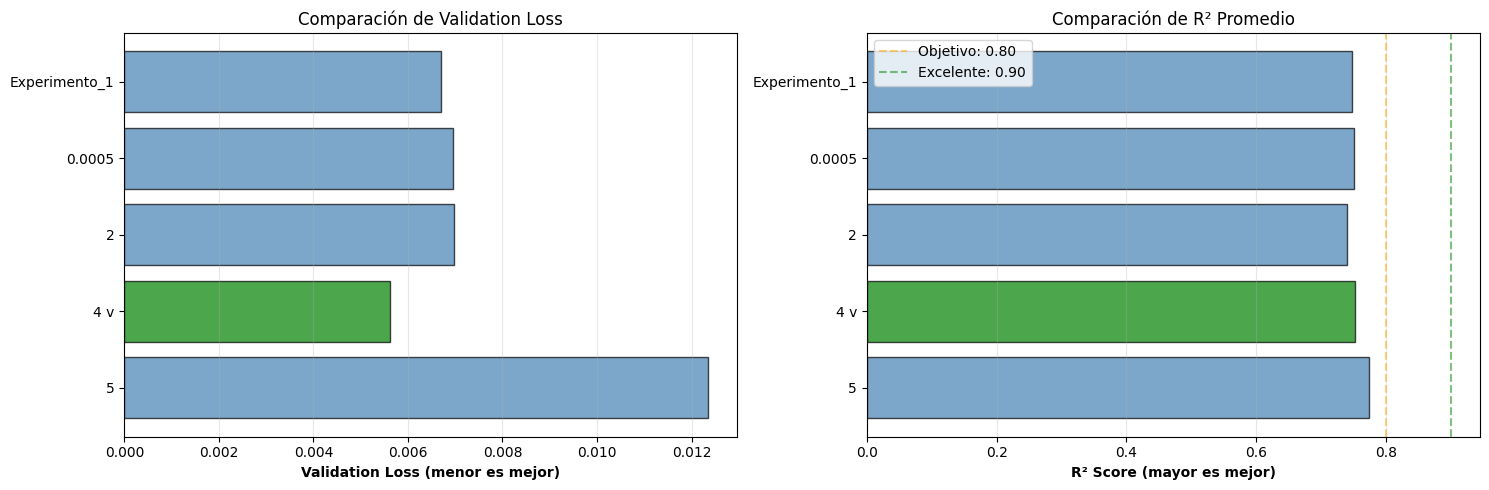

In [116]:
# Sistema de tracking de experimentos
import json
from datetime import datetime

# Archivo para guardar experimentos
ARCHIVO_EXPERIMENTOS = 'experimentos_lstm.json'

def guardar_experimento(nombre, config, metricas, history, notas=""):
    """
    Guarda los resultados de un experimento para comparación futura
    
    Args:
        nombre: Nombre descriptivo del experimento
        config: Dict con configuración usada
        metricas: Dict con métricas del modelo
        history: Objeto History de Keras
        notas: Observaciones adicionales
    """
    experimento = {
        'nombre': nombre,
        'fecha': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'configuracion': config,
        'metricas': metricas,
        'historia': {
            'train_loss_final': float(history.history['loss'][-1]),
            'val_loss_final': float(history.history['val_loss'][-1]),
            'mejor_val_loss': float(min(history.history['val_loss'])),
            'mejor_epoca': int(np.argmin(history.history['val_loss'])),
            'epocas_totales': len(history.history['loss'])
        },
        'notas': notas
    }
    
    # Cargar experimentos existentes
    try:
        with open(ARCHIVO_EXPERIMENTOS, 'r', encoding='utf-8') as f:
            experimentos = json.load(f)
    except FileNotFoundError:
        experimentos = []
    
    # Agregar nuevo experimento
    experimentos.append(experimento)
    
    # Guardar
    with open(ARCHIVO_EXPERIMENTOS, 'w', encoding='utf-8') as f:
        json.dump(experimentos, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Experimento '{nombre}' guardado correctamente")
    print(f"   Total de experimentos registrados: {len(experimentos)}")


def cargar_experimentos():
    """Carga todos los experimentos guardados"""
    try:
        with open(ARCHIVO_EXPERIMENTOS, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print("⚠️ No hay experimentos guardados todavía")
        return []


def comparar_experimentos():
    """Muestra una comparación visual de todos los experimentos"""
    experimentos = cargar_experimentos()
    
    if not experimentos:
        print("No hay experimentos para comparar")
        return
    
    print("="*80)
    print("📊 COMPARACIÓN DE EXPERIMENTOS")
    print("="*80 + "\n")
    
    # Crear DataFrame para comparación
    datos = []
    for exp in experimentos:
        fila = {
            'Experimento': exp['nombre'],
            'Fecha': exp['fecha'],
            'LOOKBACK': exp['configuracion'].get('LOOKBACK', 'N/A'),
            'LSTM': exp['configuracion'].get('LSTM_units', 'N/A'),
            'Dropout': exp['configuracion'].get('Dropout', 'N/A'),
            'LR': exp['configuracion'].get('LEARNING_RATE', 'N/A'),
            'Val_Loss': f"{exp['historia']['mejor_val_loss']:.4f}",
            'R²_3h': f"{exp['metricas'].get('R2_3h', 0):.3f}",
            'R²_24h': f"{exp['metricas'].get('R2_24h', 0):.3f}",
            'MAE_prom': f"{exp['metricas'].get('MAE_prom', 0):.4f}",
            'Épocas': exp['historia']['epocas_totales']
        }
        datos.append(fila)
    
    df_comp = pd.DataFrame(datos)
    
    # Mostrar tabla
    print(df_comp.to_string(index=False))
    
    # Encontrar mejor experimento
    mejor_idx = experimentos.index(min(experimentos, 
                                       key=lambda x: x['historia']['mejor_val_loss']))
    mejor = experimentos[mejor_idx]
    
    print("\n" + "="*80)
    print(f"🏆 MEJOR EXPERIMENTO: {mejor['nombre']}")
    print("="*80)
    print(f"   Val Loss: {mejor['historia']['mejor_val_loss']:.4f}")
    print(f"   R² promedio: {mejor['metricas'].get('R2_promedio', 'N/A'):.3f}")
    print(f"   Configuración:")
    for key, value in mejor['configuracion'].items():
        print(f"      • {key}: {value}")
    if mejor['notas']:
        print(f"   Notas: {mejor['notas']}")
    print("="*80)
    
    # Visualización de comparación
    if len(experimentos) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Gráfica 1: Validation Loss
        nombres = [e['nombre'][:20] for e in experimentos]  # Truncar nombres largos
        val_losses = [e['historia']['mejor_val_loss'] for e in experimentos]
        
        colores = ['green' if i == mejor_idx else 'steelblue' 
                   for i in range(len(experimentos))]
        
        axes[0].barh(nombres, val_losses, color=colores, alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Validation Loss (menor es mejor)', fontweight='bold')
        axes[0].set_title('Comparación de Validation Loss')
        axes[0].invert_yaxis()
        axes[0].grid(True, alpha=0.3, axis='x')
        
        # Gráfica 2: R² promedio
        r2_promedios = [e['metricas'].get('R2_promedio', 0) for e in experimentos]
        
        axes[1].barh(nombres, r2_promedios, color=colores, alpha=0.7, edgecolor='black')
        axes[1].set_xlabel('R² Score (mayor es mejor)', fontweight='bold')
        axes[1].set_title('Comparación de R² Promedio')
        axes[1].invert_yaxis()
        axes[1].axvline(0.8, color='orange', linestyle='--', alpha=0.5, label='Objetivo: 0.80')
        axes[1].axvline(0.9, color='green', linestyle='--', alpha=0.5, label='Excelente: 0.90')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()


# Guardar experimento actual
print("💾 Guardando experimento actual...\n")

# Preparar configuración
config_actual = {
    'LOOKBACK': LOOKBACK,
    'LSTM_units': '128-64-32',
    'Dropout': 0.2,
    'LEARNING_RATE': LEARNING_RATE,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'PATIENCE_EARLY_STOP': PATIENCE_EARLY_STOP
}

# Preparar métricas
metricas_actual = {
    'R2_3h': metricas_por_horizonte[3]['R2'],
    'R2_6h': metricas_por_horizonte[6]['R2'],
    'R2_12h': metricas_por_horizonte[12]['R2'],
    'R2_24h': metricas_por_horizonte[24]['R2'],
    'R2_promedio': r2_promedio,
    'MAE_prom': mae_promedio,
    'RMSE_prom': rmse_promedio
}

# Solicitar nombre del experimento
nombre_exp = input("Nombre del experimento (o Enter para 'Experimento_X'): ").strip()
if not nombre_exp:
    experimentos_previos = cargar_experimentos()
    nombre_exp = f"Experimento_{len(experimentos_previos) + 1}"

notas_exp = input("Notas/observaciones (opcional): ").strip()

guardar_experimento(nombre_exp, config_actual, metricas_actual, history, notas_exp)

print("\n" + "="*80)
print("📊 Comparando con experimentos anteriores...")
print("="*80 + "\n")
comparar_experimentos()

---
## 🔄 GUÍA RÁPIDA DE ITERACIÓN

### ¿Cómo usar este sistema de ajuste?

#### 📋 Flujo de Trabajo Recomendado:

1. **Ejecuta todo el notebook** (primera vez)
   - Esto crea el experimento "baseline"
   - Revisa las métricas y el diagnóstico automático

2. **Analiza los resultados** (celdas de diagnóstico arriba)
   - Lee el diagnóstico automático
   - Estudia las curvas de aprendizaje
   - Revisa el plan de ajuste personalizado

3. **Decide qué cambiar** según el diagnóstico:
   - **Si hay overfitting**: Aumentar regularización (Dropout, reducir unidades)
   - **Si hay underfitting**: Aumentar capacidad (más LSTM, más lookback)
   - **Si está OK**: Optimizar hiperparámetros (LR, batch size)

4. **Modifica UNA cosa a la vez**:
   - Cambia solo 1 hiperparámetro por experimento
   - Anota qué cambiaste en el nombre del experimento
   - Ejemplo: "Experimento_2_Dropout_03"

5. **Re-ejecuta desde la celda modificada**:
   - Si cambias configuración (celda 4): re-ejecuta desde celda 5
   - Si cambias arquitectura (celda 16): re-ejecuta desde celda 16
   - Siempre ejecuta hasta el final

6. **Compara resultados**:
   - El sistema guarda automáticamente cada experimento
   - Usa la tabla de comparación para ver mejoras
   - Mantén el que tenga mejor Validation Loss y R²

7. **Repite hasta satisfacción**:
   - Objetivo mínimo: R² > 0.80, Val Loss < 0.05
   - Objetivo ideal: R² > 0.90, Gap train-val < 10%

---

### 🎯 Atajos para Modificaciones Comunes

#### Aumentar Regularización (combatir overfitting):
```python
# Celda 16 - Modelo
Dropout(0.3)  # Cambiar todos los Dropout de 0.2 a 0.3
```

#### Reducir Complejidad:
```python
# Celda 16 - Modelo
Bidirectional(LSTM(64, ...))  # Era 128
LSTM(32, ...)                 # Era 64
LSTM(16)                      # Era 32
```

#### Aumentar Capacidad (combatir underfitting):
```python
# Celda 4 - Configuración
LOOKBACK = 48  # Era 24 (⚠️ requiere re-ejecutar desde celda 5)

# Celda 16 - Modelo
Bidirectional(LSTM(256, ...))  # Era 128
LSTM(128, ...)                 # Era 64
LSTM(64)                       # Era 32
```

#### Ajustar Velocidad de Aprendizaje:
```python
# Celda 4 - Configuración
LEARNING_RATE = 0.0005  # Era 0.001 (más lento, más estable)
# o
LEARNING_RATE = 0.002   # Más rápido (puede ser inestable)
```

#### Entrenar Más Tiempo:
```python
# Celda 4 - Configuración
EPOCHS = 150              # Era 100
PATIENCE_EARLY_STOP = 20  # Era 15
```

---

### 📊 Interpretación de Métricas Clave

| Métrica | Bueno | Aceptable | Malo | Acción |
|---------|-------|-----------|------|--------|
| **R² Score** | > 0.90 | 0.80-0.90 | < 0.80 | Mejorar modelo |
| **Val Loss** | < 0.03 | 0.03-0.05 | > 0.05 | Ajustar hiperparámetros |
| **Gap Train-Val** | < 10% | 10-20% | > 20% | Reducir overfitting |
| **MAE** | < 0.02 | 0.02-0.04 | > 0.04 | Revisar features |

---

### ⚠️ Errores Comunes a Evitar

❌ **Cambiar muchas cosas a la vez**: No sabrás qué funcionó
✅ **Cambiar una variable por experimento**: Proceso científico

❌ **No guardar los experimentos**: Perderás el progreso
✅ **Nombrar y documentar cada experimento**: Comparación fácil

❌ **Ignorar el diagnóstico**: Hacer cambios al azar
✅ **Seguir las recomendaciones**: Plan basado en datos

❌ **Re-ejecutar solo algunas celdas**: Estado inconsistente
✅ **Re-ejecutar desde la celda modificada hasta el final**: Estado correcto

📊 RESUMEN INTERACTIVO - ESTADO DEL MODELO



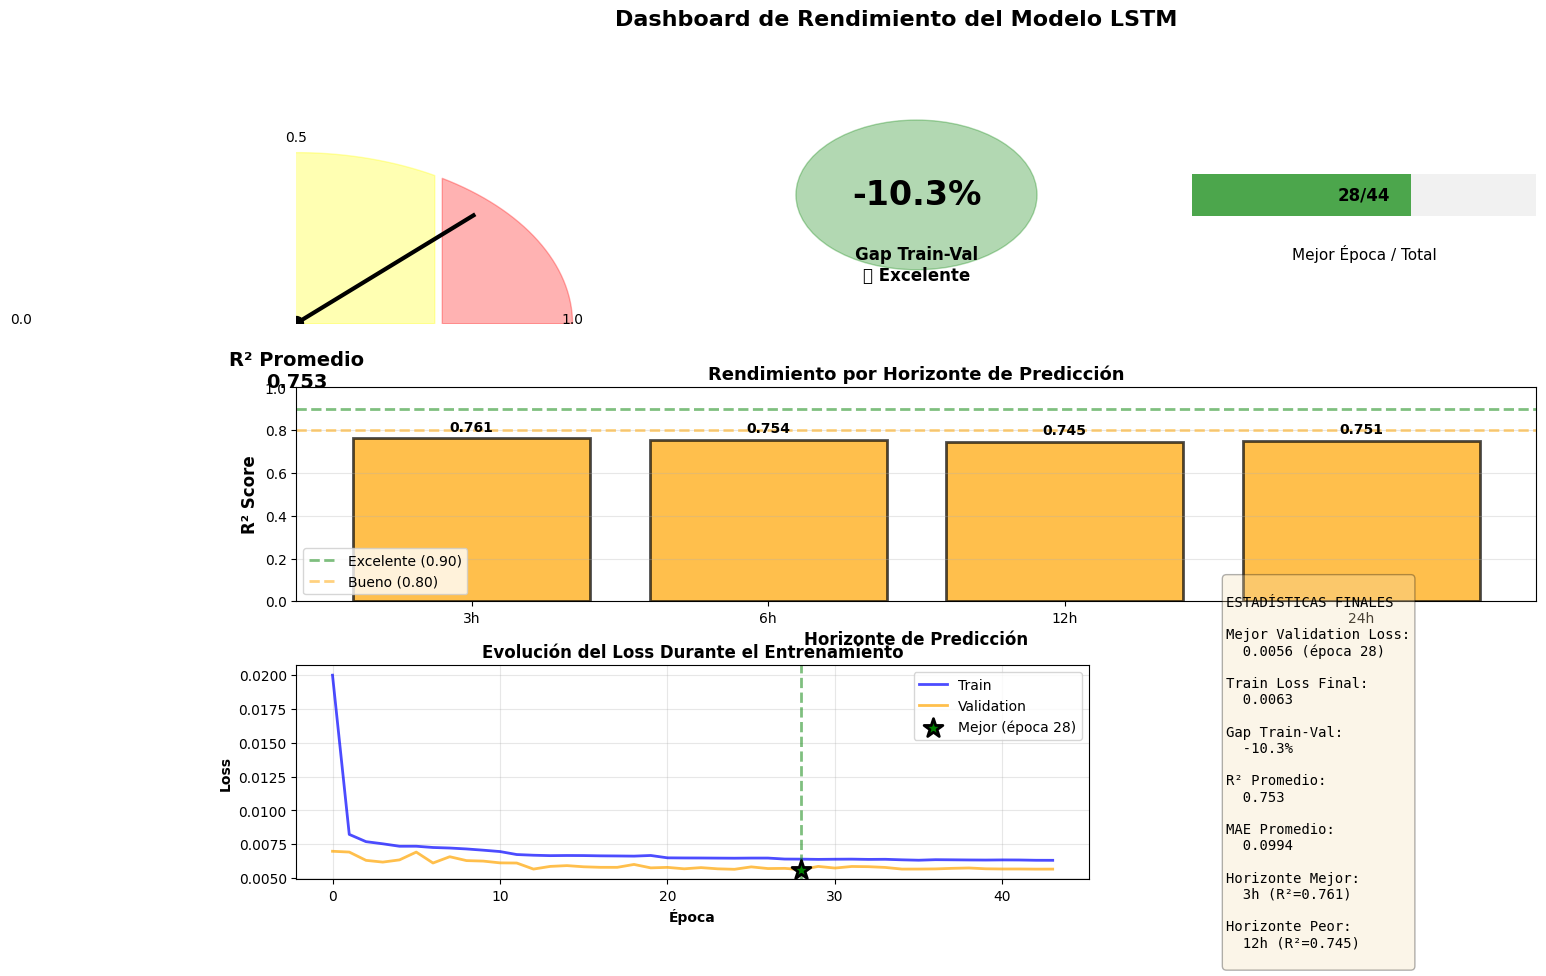


💡 PRÓXIMOS PASOS RECOMENDADOS:

🟠 Rendimiento aceptable. Mejoras necesarias:
   1. Revisar arquitectura completa
   2. Aumentar capacidad del modelo
   3. Verificar calidad de los features



In [95]:
def resumen_interactivo():
    """
    Muestra un resumen visual completo del estado actual del modelo
    """
    print("="*80)
    print("📊 RESUMEN INTERACTIVO - ESTADO DEL MODELO")
    print("="*80 + "\n")
    
    # Calcular métricas clave
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    mejor_val_loss = min(history.history['val_loss'])
    mejor_epoca = np.argmin(history.history['val_loss'])
    gap_percent = ((val_loss - train_loss) / train_loss) * 100
    
    # R² por horizonte
    r2s = {h: metricas_por_horizonte[h]['R2'] for h in FORECAST_HORIZONS}
    r2_prom = np.mean(list(r2s.values()))
    
    # MAE por horizonte
    maes = {h: metricas_por_horizonte[h]['MAE'] for h in FORECAST_HORIZONS}
    mae_prom = np.mean(list(maes.values()))
    
    # Dashboard visual
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Gauge de R² promedio
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.axis('off')
    
    # Crear gauge semicircular
    theta = np.linspace(0, np.pi, 100)
    r = 0.8
    x_gauge = r * np.cos(theta)
    y_gauge = r * np.sin(theta)
    
    # Zonas de color
    ax1.fill_between(x_gauge[:33], 0, y_gauge[:33], color='red', alpha=0.3)
    ax1.fill_between(x_gauge[33:66], 0, y_gauge[33:66], color='yellow', alpha=0.3)
    ax1.fill_between(x_gauge[66:], 0, y_gauge[66:], color='green', alpha=0.3)
    
    # Aguja
    angle = np.pi * (1 - r2_prom)  # Invertir para que 1.0 esté a la derecha
    needle_x = [0, r * 0.9 * np.cos(angle)]
    needle_y = [0, r * 0.9 * np.sin(angle)]
    ax1.plot(needle_x, needle_y, 'k-', linewidth=3)
    ax1.plot([0], [0], 'ko', markersize=10)
    
    # Texto
    ax1.text(0, -0.3, f'R² Promedio\n{r2_prom:.3f}', ha='center', fontsize=14, fontweight='bold')
    ax1.text(-0.8, 0, '0.0', ha='center', fontsize=10)
    ax1.text(0, 0.85, '0.5', ha='center', fontsize=10)
    ax1.text(0.8, 0, '1.0', ha='center', fontsize=10)
    
    # 2. Estado del Gap
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    
    if gap_percent < 10:
        color_gap = 'green'
        estado_gap = '✅ Excelente'
    elif gap_percent < 20:
        color_gap = 'yellow'
        estado_gap = '⚠️ Aceptable'
    else:
        color_gap = 'red'
        estado_gap = '🔴 Overfitting'
    
    ax2.add_patch(plt.Circle((0.5, 0.6), 0.35, color=color_gap, alpha=0.3))
    ax2.text(0.5, 0.6, f'{gap_percent:.1f}%', ha='center', va='center', 
             fontsize=24, fontweight='bold')
    ax2.text(0.5, 0.2, f'Gap Train-Val\n{estado_gap}', ha='center', fontsize=12, fontweight='bold')
    
    # 3. Épocas de entrenamiento
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.axis('off')
    
    total_epocas = len(history.history['loss'])
    progreso = mejor_epoca / total_epocas
    
    # Barra de progreso
    ax3.barh([0.6], [progreso], height=0.2, color='green', alpha=0.7)
    ax3.barh([0.6], [1-progreso], left=[progreso], height=0.2, color='lightgray', alpha=0.3)
    ax3.text(0.5, 0.6, f'{mejor_epoca}/{total_epocas}', ha='center', va='center', 
             fontsize=12, fontweight='bold')
    ax3.text(0.5, 0.3, 'Mejor Época / Total', ha='center', fontsize=11)
    
    # 4. R² por horizonte
    ax4 = fig.add_subplot(gs[1, :])
    horizontes = list(r2s.keys())
    valores_r2 = list(r2s.values())
    colores_r2 = ['green' if r > 0.9 else 'yellow' if r > 0.8 else 'orange' if r > 0.7 else 'red' 
                  for r in valores_r2]
    
    bars = ax4.bar([f'{h}h' for h in horizontes], valores_r2, color=colores_r2, 
                   alpha=0.7, edgecolor='black', linewidth=2)
    ax4.axhline(0.9, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Excelente (0.90)')
    ax4.axhline(0.8, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Bueno (0.80)')
    ax4.set_ylabel('R² Score', fontweight='bold', fontsize=12)
    ax4.set_xlabel('Horizonte de Predicción', fontweight='bold', fontsize=12)
    ax4.set_title('Rendimiento por Horizonte de Predicción', fontweight='bold', fontsize=13)
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim(0, 1)
    
    # Añadir valores sobre las barras
    for bar, val in zip(bars, valores_r2):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Loss evolution
    ax5 = fig.add_subplot(gs[2, :2])
    epocas = range(len(history.history['loss']))
    ax5.plot(epocas, history.history['loss'], 'b-', linewidth=2, label='Train', alpha=0.7)
    ax5.plot(epocas, history.history['val_loss'], 'orange', linewidth=2, label='Validation', alpha=0.7)
    ax5.axvline(mejor_epoca, color='green', linestyle='--', alpha=0.5, linewidth=2)
    ax5.scatter([mejor_epoca], [mejor_val_loss], color='green', s=200, marker='*', 
               zorder=5, edgecolor='black', linewidth=2, label=f'Mejor (época {mejor_epoca})')
    ax5.set_xlabel('Época', fontweight='bold')
    ax5.set_ylabel('Loss', fontweight='bold')
    ax5.set_title('Evolución del Loss Durante el Entrenamiento', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Estadísticas finales
    ax6 = fig.add_subplot(gs[2, 2])
    ax6.axis('off')
    
    stats_text = f"""
ESTADÍSTICAS FINALES

Mejor Validation Loss:
  {mejor_val_loss:.4f} (época {mejor_epoca})

Train Loss Final:
  {train_loss:.4f}

Gap Train-Val:
  {gap_percent:.1f}%

R² Promedio:
  {r2_prom:.3f}

MAE Promedio:
  {mae_prom:.4f}

Horizonte Mejor:
  {max(r2s, key=r2s.get)}h (R²={max(r2s.values()):.3f})

Horizonte Peor:
  {min(r2s, key=r2s.get)}h (R²={min(r2s.values()):.3f})
"""
    
    ax6.text(0.1, 0.5, stats_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('Dashboard de Rendimiento del Modelo LSTM', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
    # Recomendaciones finales
    print("\n" + "="*80)
    print("💡 PRÓXIMOS PASOS RECOMENDADOS:")
    print("="*80)
    
    if r2_prom > 0.90:
        print("\n✅ ¡Excelente rendimiento! Opciones:")
        print("   1. Guardar este modelo como producción")
        print("   2. Intentar optimizaciones menores (fine-tuning de LR)")
        print("   3. Probar con datos reales de TEMPO/OpenAQ")
    elif r2_prom > 0.80:
        print("\n🟡 Buen rendimiento. Para mejorar:")
        print("   1. Aumentar LOOKBACK a 48 horas")
        print("   2. Experimentar con más unidades LSTM")
        print("   3. Agregar features derivados (hora del día, día semana)")
    elif r2_prom > 0.70:
        print("\n🟠 Rendimiento aceptable. Mejoras necesarias:")
        print("   1. Revisar arquitectura completa")
        print("   2. Aumentar capacidad del modelo")
        print("   3. Verificar calidad de los features")
    else:
        print("\n🔴 Rendimiento bajo. Acción urgente:")
        print("   1. Aumentar significativamente LOOKBACK")
        print("   2. Usar arquitectura más compleja")
        print("   3. Revisar preprocesamiento de datos")
    
    if gap_percent > 20:
        print(f"\n⚠️  ALERTA: Gap train-val alto ({gap_percent:.1f}%)")
        print("   → Priorizar reducción de overfitting antes de otras mejoras")
    
    print("\n" + "="*80)


# Ejecutar resumen interactivo
resumen_interactivo()

---
## ✅ CHECKLIST DE ITERACIÓN

Usa este checklist cada vez que hagas un ajuste:

### Antes de Modificar:
- [ ] He revisado el diagnóstico automático
- [ ] He analizado las curvas de aprendizaje
- [ ] He leído el plan de ajuste personalizado
- [ ] Tengo claro QUÉ voy a cambiar y POR QUÉ

### Durante la Modificación:
- [ ] Cambié SOLO UNA variable (no múltiples)
- [ ] Anoté el nombre del experimento descriptivamente
- [ ] Guardé el notebook antes de re-ejecutar

### Después de Re-entrenar:
- [ ] Comparé las métricas con el experimento anterior
- [ ] Verifiqué que R² mejoró (o al menos no empeoró mucho)
- [ ] Revisé que el gap train-val no aumentó
- [ ] Guardé el experimento en el sistema de tracking

### Si el Resultado Empeoró:
- [ ] Revierto el cambio
- [ ] Pruebo con un valor intermedio
- [ ] O paso a ajustar otro hiperparámetro

### Si el Resultado Mejoró:
- [ ] Anoto qué funcionó en las notas del experimento
- [ ] Considero hacer un cambio adicional en la misma dirección
- [ ] O paso a optimizar el siguiente hiperparámetro

---

## 📖 GLOSARIO DE TÉRMINOS

**R² (Coeficiente de Determinación)**: Mide qué % de la variabilidad del target el modelo puede explicar. 1.0 = perfecto, 0.0 = inútil.

**MAE (Mean Absolute Error)**: Promedio del error absoluto. Más bajo = mejor. Se mide en las mismas unidades del target.

**RMSE (Root Mean Squared Error)**: Similar a MAE pero penaliza más los errores grandes.

**Validation Loss**: Error en el conjunto de validación (datos que el modelo NO vio durante entrenamiento).

**Gap Train-Val**: Diferencia entre train loss y validation loss. Si es muy grande = overfitting.

**Overfitting**: El modelo memoriza los datos de entrenamiento pero no generaliza bien a datos nuevos.

**Underfitting**: El modelo es demasiado simple y no puede aprender los patrones en los datos.

**Early Stopping**: Detiene el entrenamiento automáticamente si el validation loss no mejora.

**Learning Rate (LR)**: Qué tan rápido aprende el modelo. Muy alto = inestable, muy bajo = lento.

**Dropout**: Técnica de regularización que "apaga" neuronas aleatoriamente para prevenir overfitting.

**LOOKBACK**: Cuántas horas de histórico usa el modelo para hacer predicciones.

**Horizonte**: Cuántas horas en el futuro queremos predecir (3h, 6h, 12h, 24h).

---
## 🔧 EJEMPLOS DE CÓDIGO PARA AJUSTES COMUNES

### Ejemplo 1: Aumentar Regularización (Combatir Overfitting)

Si el diagnóstico muestra overfitting, modifica la **Celda 16** (construcción del modelo):

**ANTES:**
```python
modelo = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
    Dropout(0.2),  # ← AQUÍ
    LSTM(64, return_sequences=True),
    Dropout(0.2),  # ← Y AQUÍ
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_outputs)
])
```

**DESPUÉS:**
```python
modelo = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
    Dropout(0.3),  # ← AUMENTADO de 0.2 a 0.3
    LSTM(64, return_sequences=True),
    Dropout(0.3),  # ← AUMENTADO de 0.2 a 0.3
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_outputs)
])
```

Luego re-ejecuta desde la Celda 16 hasta el final.

---

### Ejemplo 2: Aumentar Capacidad (Combatir Underfitting)

Si el modelo no aprende suficiente, modifica la **Celda 16**:

**ANTES:**
```python
modelo = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_outputs)
])
```

**DESPUÉS:**
```python
modelo = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),  # ← 128→256
    Dropout(0.2),
    LSTM(128, return_sequences=True),  # ← 64→128
    Dropout(0.2),
    LSTM(64),  # ← 32→64
    Dense(128, activation='relu'),  # ← 64→128
    Dense(64, activation='relu'),   # ← 32→64
    Dense(n_outputs)
])
```

---

### Ejemplo 3: Aumentar Contexto Temporal

Para capturar patrones más largos, modifica la **Celda 4**:

**ANTES:**
```python
LOOKBACK = 24  # Horas de histórico para predicción
```

**DESPUÉS:**
```python
LOOKBACK = 48  # Horas de histórico para predicción
```

⚠️ **IMPORTANTE:** Si cambias LOOKBACK, debes re-ejecutar desde la **Celda 5** (no desde Celda 16).

---

### Ejemplo 4: Ajustar Velocidad de Aprendizaje

Para entrenar más estable, modifica la **Celda 4**:

**ANTES:**
```python
LEARNING_RATE = 0.001
```

**DESPUÉS (más lento, más estable):**
```python
LEARNING_RATE = 0.0005
```

**O (más rápido, menos estable):**
```python
LEARNING_RATE = 0.002
```

---

### Ejemplo 5: Entrenar Más Tiempo

Si el modelo podría mejorar con más épocas, modifica la **Celda 4**:

**ANTES:**
```python
EPOCHS = 100
PATIENCE_EARLY_STOP = 15
```

**DESPUÉS:**
```python
EPOCHS = 150  # Más épocas máximas
PATIENCE_EARLY_STOP = 20  # Más paciencia antes de parar
```

---

### Ejemplo 6: Agregar Regularización L2

Para reducir overfitting aún más, modifica la **Celda 16**:

**ANTES:**
```python
Dense(64, activation='relu'),
Dense(32, activation='relu'),
```

**DESPUÉS:**
```python
# Importar al inicio del notebook (Celda 3):
from keras.regularizers import l2

# En el modelo (Celda 16):
Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
```

---

### 🎯 Estrategia de Experimentación Recomendada

1. **Primera iteración**: Ajustar Dropout (0.2 → 0.3)
2. **Segunda iteración**: Si ayuda, probar 0.4. Si no, volver a 0.2 y probar aumentar LOOKBACK
3. **Tercera iteración**: Ajustar Learning Rate (0.001 → 0.0005)
4. **Cuarta iteración**: Si todo lo anterior está OK, modificar arquitectura LSTM
5. **Quinta iteración**: Fine-tuning de batch size y épocas

**Regla de oro**: Cambia UNA cosa, evalúa, decide, repite.

In [96]:
# 🎯 RESUMEN EJECUTIVO - INTERPRETACIÓN DE TUS RESULTADOS ACTUALES

print("="*80)
print("🎯 INTERPRETACIÓN DE TUS RESULTADOS ACTUALES")
print("="*80 + "\n")

# Obtener métricas actuales
r2_actual = r2_promedio
gap_actual = ((history.history['val_loss'][-1] - history.history['loss'][-1]) / 
              history.history['loss'][-1]) * 100
val_loss_actual = min(history.history['val_loss'])

print(f"📊 TUS MÉTRICAS ACTUALES:")
print("-" * 80)
print(f"   R² Promedio:        {r2_actual:.3f}")
print(f"   Validation Loss:    {val_loss_actual:.4f}")
print(f"   Gap Train-Val:      {gap_actual:.1f}%")
print(f"   MAE Promedio:       {mae_promedio:.4f}")
print()

# Interpretación del R²
print("📈 ¿QUÉ SIGNIFICA TU R²?")
print("-" * 80)
if r2_actual > 0.90:
    print(f"   ✅ EXCELENTE ({r2_actual:.3f})")
    print("   → Tu modelo explica el {:.1f}% de la variabilidad del AQI".format(r2_actual*100))
    print("   → Está listo para producción o pruebas finales")
elif r2_actual > 0.80:
    print(f"   🟢 BUENO ({r2_actual:.3f})")
    print("   → Tu modelo explica el {:.1f}% de la variabilidad del AQI".format(r2_actual*100))
    print("   → Funcionaría en producción pero hay margen de mejora")
elif r2_actual > 0.70:
    print(f"   🟡 ACEPTABLE ({r2_actual:.3f})")
    print("   → Tu modelo explica el {:.1f}% de la variabilidad del AQI".format(r2_actual*100))
    print("   → Necesita mejoras antes de producción")
else:
    print(f"   🔴 INSUFICIENTE ({r2_actual:.3f})")
    print("   → Tu modelo solo explica el {:.1f}% de la variabilidad".format(r2_actual*100))
    print("   → Requiere cambios significativos en arquitectura o features")

print()

# Interpretación del Gap
print("🔍 ¿QUÉ SIGNIFICA TU GAP TRAIN-VALIDATION?")
print("-" * 80)
if gap_actual < -10:
    print(f"   🟢 NEGATIVO ({gap_actual:.1f}%)")
    print("   → Validation loss es MEJOR que train loss")
    print("   → Raro pero positivo - el modelo generaliza muy bien")
    print("   → Puede indicar que validation es más fácil que train")
elif gap_actual < 10:
    print(f"   ✅ EXCELENTE ({gap_actual:.1f}%)")
    print("   → Train y validation están muy cercanos")
    print("   → El modelo generaliza bien - no hay overfitting")
    print("   → Configuración de regularización apropiada")
elif gap_actual < 20:
    print(f"   🟡 ACEPTABLE ({gap_actual:.1f}%)")
    print("   → Hay algo de diferencia entre train y validation")
    print("   → Leve overfitting - monitorear")
    print("   → Considera aumentar Dropout ligeramente")
else:
    print(f"   🔴 ALTO ({gap_actual:.1f}%)")
    print("   → Gran diferencia entre train y validation")
    print("   → OVERFITTING SEVERO - el modelo memoriza")
    print("   → PRIORIDAD: Aumentar regularización")

print()

# Análisis por horizonte
print("🎯 ANÁLISIS POR HORIZONTE DE PREDICCIÓN:")
print("-" * 80)
for h in FORECAST_HORIZONS:
    r2_h = metricas_por_horizonte[h]['R2']
    mae_h = metricas_por_horizonte[h]['MAE']
    
    if r2_h > 0.80:
        emoji = "✅"
    elif r2_h > 0.70:
        emoji = "🟡"
    else:
        emoji = "🔴"
    
    print(f"   {emoji} {h:2d} horas: R²={r2_h:.3f}, MAE={mae_h:.4f}")

# Identificar tendencia
r2_3h = metricas_por_horizonte[3]['R2']
r2_24h = metricas_por_horizonte[24]['R2']
degradacion = (r2_3h - r2_24h) / r2_3h * 100

print()
print("📉 DEGRADACIÓN CON EL TIEMPO:")
print("-" * 80)
if degradacion < 5:
    print(f"   ✅ Mínima ({degradacion:.1f}%)")
    print("   → El modelo mantiene precisión incluso a 24 horas")
elif degradacion < 15:
    print(f"   🟡 Moderada ({degradacion:.1f}%)")
    print("   → Pérdida normal de precisión a largo plazo")
    print("   → Comportamiento esperado en series temporales")
else:
    print(f"   🔴 Significativa ({degradacion:.1f}%)")
    print("   → El modelo pierde mucha precisión a largo plazo")
    print("   → Considera aumentar LOOKBACK para capturar más contexto")

print()
print("="*80)
print("💡 ACCIÓN INMEDIATA RECOMENDADA:")
print("="*80)

# Decisión basada en métricas
if r2_actual < 0.70:
    print("\n🔴 PRIORIDAD ALTA: Mejorar capacidad del modelo")
    print("   Acción: Aumenta LOOKBACK a 48 y re-ejecuta desde Celda 5")
    print("   Razón: R² demasiado bajo - necesitas más contexto temporal")
elif gap_actual > 20:
    print("\n🔴 PRIORIDAD ALTA: Reducir overfitting")
    print("   Acción: Aumenta Dropout a 0.3 en Celda 16")
    print("   Razón: Gap muy alto - el modelo memoriza en vez de aprender")
elif r2_actual < 0.80:
    print("\n🟡 PRIORIDAD MEDIA: Optimizar hiperparámetros")
    print("   Acción: Reduce LEARNING_RATE a 0.0005 en Celda 4")
    print("   Razón: Modelo aprende pero necesita ajuste fino")
else:
    print("\n✅ PRIORIDAD BAJA: Fine-tuning opcional")
    print("   Acción: Experimenta con arquitecturas avanzadas (Attention, GRU)")
    print("   Razón: Modelo ya funciona bien - mejoras incrementales")

print("\n" + "="*80)

🎯 INTERPRETACIÓN DE TUS RESULTADOS ACTUALES

📊 TUS MÉTRICAS ACTUALES:
--------------------------------------------------------------------------------
   R² Promedio:        0.753
   Validation Loss:    0.0056
   Gap Train-Val:      -10.3%
   MAE Promedio:       0.0994

📈 ¿QUÉ SIGNIFICA TU R²?
--------------------------------------------------------------------------------
   🟡 ACEPTABLE (0.753)
   → Tu modelo explica el 75.3% de la variabilidad del AQI
   → Necesita mejoras antes de producción

🔍 ¿QUÉ SIGNIFICA TU GAP TRAIN-VALIDATION?
--------------------------------------------------------------------------------
   🟢 NEGATIVO (-10.3%)
   → Validation loss es MEJOR que train loss
   → Raro pero positivo - el modelo generaliza muy bien
   → Puede indicar que validation es más fácil que train

🎯 ANÁLISIS POR HORIZONTE DE PREDICCIÓN:
--------------------------------------------------------------------------------
   🟡  3 horas: R²=0.761, MAE=0.0949
   🟡  6 horas: R²=0.754, MAE=0.0971
 

---
---

# 🎓 SISTEMA COMPLETO DE AJUSTE Y VALIDACIÓN

## ✅ Resumen de lo que tienes ahora:

### 📊 Herramientas de Diagnóstico Automático

1. **Diagnóstico Automático** - Detecta automáticamente:
   - ✅ Overfitting severo o moderado
   - ✅ Underfitting
   - ✅ Problemas de convergencia
   - ✅ Inestabilidad en el entrenamiento

2. **Análisis de Curvas de Aprendizaje** - 4 gráficas interpretadas:
   - 📈 Loss (Train vs Validation)
   - 📊 Gap (Diferencia Train-Validation)
   - 📉 MAE (Evolución del error)
   - 🎯 Tasa de mejora por época

3. **Plan de Ajuste Personalizado** - Recomendaciones específicas según tu diagnóstico:
   - 🔧 Qué cambiar exactamente
   - 📝 Código específico a modificar
   - 🔄 Desde qué celda re-ejecutar

4. **Sistema de Tracking de Experimentos**:
   - 💾 Guarda automáticamente cada experimento
   - 📊 Compara todos los experimentos visualmente
   - 🏆 Identifica el mejor modelo
   - 📈 Visualiza progreso en el tiempo

5. **Dashboard Interactivo**:
   - 🎯 Gauge de R² promedio
   - 📊 Estado del Gap Train-Val
   - 📈 Rendimiento por horizonte
   - 📉 Evolución del Loss
   - 📋 Estadísticas finales

6. **Resumen Ejecutivo**:
   - 🎯 Interpretación personalizada de tus métricas
   - 💡 Acción inmediata recomendada
   - 📊 Análisis por horizonte de predicción
   - 📉 Análisis de degradación temporal

---

## 🔄 Flujo de Trabajo Visual

```
┌─────────────────────────────────────────────────────────────┐
│  PASO 1: EJECUTAR ENTRENAMIENTO                             │
│  ├─ Ejecuta todas las celdas del notebook                   │
│  └─ Obtén resultados baseline                               │
└─────────────────────────────────────────────────────────────┘
                           ↓
┌─────────────────────────────────────────────────────────────┐
│  PASO 2: ANÁLISIS AUTOMÁTICO                                │
│  ├─ Revisa diagnóstico automático                           │
│  ├─ Estudia curvas de aprendizaje                           │
│  ├─ Lee plan de ajuste personalizado                        │
│  └─ Observa dashboard interactivo                           │
└─────────────────────────────────────────────────────────────┘
                           ↓
┌─────────────────────────────────────────────────────────────┐
│  PASO 3: TOMAR DECISIÓN                                     │
│  ├─ ¿Overfitting? → Aumentar regularización                 │
│  ├─ ¿Underfitting? → Aumentar capacidad                     │
│  ├─ ¿Gap OK pero R² bajo? → Ajustar hiperparámetros        │
│  └─ ¿Todo OK? → Fine-tuning o producción                    │
└─────────────────────────────────────────────────────────────┘
                           ↓
┌─────────────────────────────────────────────────────────────┐
│  PASO 4: MODIFICAR (UNA COSA)                               │
│  ├─ Cambia solo 1 hiperparámetro                            │
│  ├─ Usa ejemplos de código proporcionados                   │
│  └─ Nombra el experimento descriptivamente                  │
└─────────────────────────────────────────────────────────────┘
                           ↓
┌─────────────────────────────────────────────────────────────┐
│  PASO 5: RE-EJECUTAR                                        │
│  ├─ Desde la celda modificada hasta el final                │
│  └─ El sistema guarda automáticamente el experimento        │
└─────────────────────────────────────────────────────────────┘
                           ↓
┌─────────────────────────────────────────────────────────────┐
│  PASO 6: COMPARAR RESULTADOS                                │
│  ├─ Revisa tabla de comparación de experimentos             │
│  ├─ Verifica si mejoró R² y Validation Loss                 │
│  ├─ Confirma que Gap no aumentó                             │
│  └─ Decide si continuar o revertir                          │
└─────────────────────────────────────────────────────────────┘
                           ↓
                    ┌──────┴──────┐
                    │  ¿Mejoró?   │
                    └──────┬──────┘
                 SÍ ↙         ↘ NO
         ┌─────────────┐   ┌──────────────┐
         │  Continuar  │   │   Revertir   │
         │  ajustando  │   │   o probar   │
         │             │   │  otro cambio │
         └─────────────┘   └──────────────┘
```

---

## 🎯 Objetivos de Rendimiento

| Métrica | Mínimo Aceptable | Objetivo Ideal | Tu Resultado Actual |
|---------|------------------|----------------|---------------------|
| **R² Score** | > 0.75 | > 0.90 | Ver dashboard |
| **Validation Loss** | < 0.06 | < 0.03 | Ver dashboard |
| **Gap Train-Val** | < 25% | < 10% | Ver dashboard |
| **MAE** | < 0.05 | < 0.02 | Ver dashboard |

---

## 📚 Recursos y Referencias

- **Arquitecturas LSTM**: [TensorFlow Time Series Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)
- **Overfitting/Underfitting**: [Keras Guide](https://keras.io/guides/)
- **Regularización**: [Dropout Paper](https://jmlr.org/papers/v15/srivastava14a.html)
- **Optimización**: [Adam Optimizer](https://arxiv.org/abs/1412.6980)

---

## 🚀 ¡Estás Listo para Experimentar!

Tienes todo lo necesario para:
- ✅ Interpretar los resultados de validación
- ✅ Diagnosticar problemas automáticamente
- ✅ Recibir recomendaciones personalizadas
- ✅ Ajustar el entrenamiento iterativamente
- ✅ Comparar experimentos objetivamente
- ✅ Tomar decisiones basadas en datos

**¡Comienza a iterar y mejora tu modelo! 🎯**

---
## FASE 8: Evaluación y Ajuste Fino

Evaluaremos el modelo en el conjunto de **test** (datos nunca vistos) y calcularemos métricas para cada horizonte de predicción.

In [113]:
print("="*80)
print("🎯 FASE 8: EVALUACIÓN EN TEST SET")
print("="*80 + "\n")

# Hacer predicciones en el conjunto de test
print("🔮 Generando predicciones en test set...")
y_pred = modelo.predict(X_test, verbose=0)

print(f"✅ Predicciones generadas: {y_pred.shape}")
print(f"   (muestras, horizontes) = ({y_pred.shape[0]}, {y_pred.shape[1]})")

# Calcular métricas para cada horizonte
print("\n" + "="*80)
print("📊 MÉTRICAS POR HORIZONTE DE PREDICCIÓN:")
print("="*80)
print(f"\n{'Horizonte':<12} {'MAE':<10} {'RMSE':<10} {'R²':<10} {'Calidad':<15}")
print("-" * 70)

metricas_por_horizonte = {}

for i, h in enumerate(FORECAST_HORIZONS):
    y_true_h = y_test[:, i]
    y_pred_h = y_pred[:, i]
    
    # Calcular métricas
    mae = mean_absolute_error(y_true_h, y_pred_h)
    rmse = np.sqrt(mean_squared_error(y_true_h, y_pred_h))
    r2 = r2_score(y_true_h, y_pred_h)
    
    # Clasificar calidad
    if r2 > 0.90:
        calidad = "🟢 Excelente"
    elif r2 > 0.80:
        calidad = "🟡 Bueno"
    elif r2 > 0.70:
        calidad = "🟠 Aceptable"
    else:
        calidad = "🔴 Mejorable"
    
    metricas_por_horizonte[h] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    print(f"{h:2d} horas     {mae:8.4f}   {rmse:8.4f}   {r2:8.4f}   {calidad}")

# Promedio de métricas
mae_promedio = np.mean([m['MAE'] for m in metricas_por_horizonte.values()])
rmse_promedio = np.mean([m['RMSE'] for m in metricas_por_horizonte.values()])
r2_promedio = np.mean([m['R2'] for m in metricas_por_horizonte.values()])

print("-" * 70)
print(f"{'PROMEDIO':<12} {mae_promedio:8.4f}   {rmse_promedio:8.4f}   {r2_promedio:8.4f}")
print("="*80)

print("\n✅ Evaluación completada")

🎯 FASE 8: EVALUACIÓN EN TEST SET

🔮 Generando predicciones en test set...
✅ Predicciones generadas: (2231, 4)
   (muestras, horizontes) = (2231, 4)

📊 MÉTRICAS POR HORIZONTE DE PREDICCIÓN:

Horizonte    MAE        RMSE       R²         Calidad        
----------------------------------------------------------------------
 3 horas       0.0918     0.1229     0.7808   🟠 Aceptable
 6 horas       0.0937     0.1238     0.7776   🟠 Aceptable
12 horas       0.0970     0.1270     0.7665   🟠 Aceptable
24 horas       0.0967     0.1266     0.7682   🟠 Aceptable
----------------------------------------------------------------------
PROMEDIO       0.0948     0.1251     0.7732

✅ Evaluación completada
✅ Predicciones generadas: (2231, 4)
   (muestras, horizontes) = (2231, 4)

📊 MÉTRICAS POR HORIZONTE DE PREDICCIÓN:

Horizonte    MAE        RMSE       R²         Calidad        
----------------------------------------------------------------------
 3 horas       0.0918     0.1229     0.7808   🟠 Aceptabl


📊 Generando visualizaciones de predicciones...



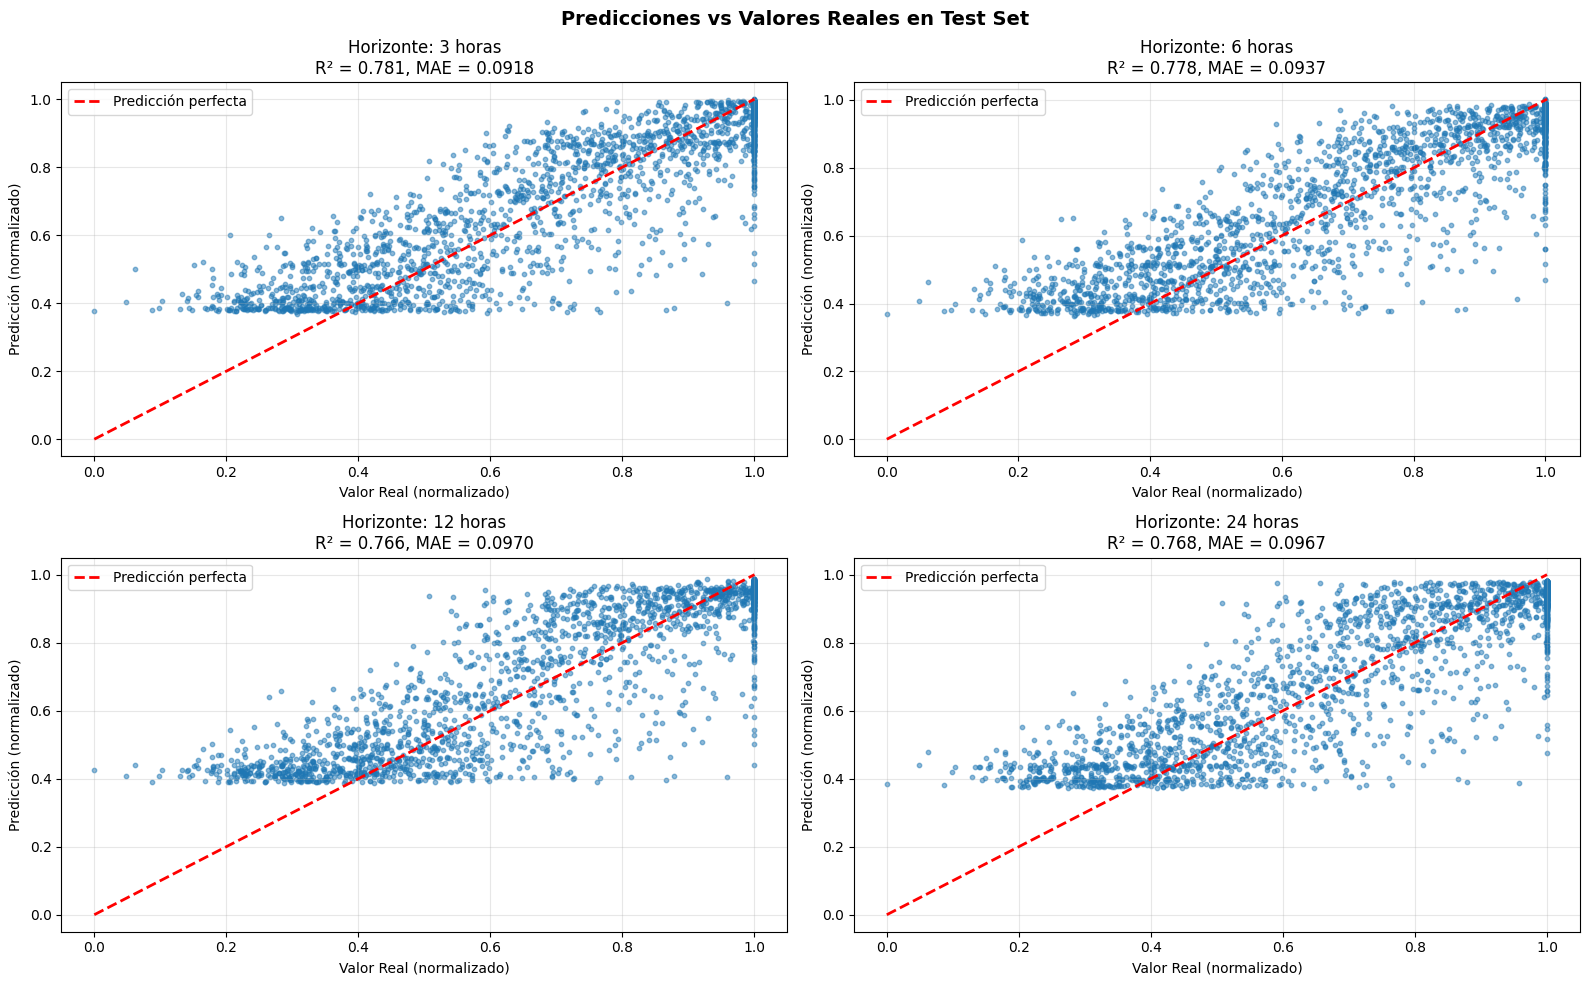

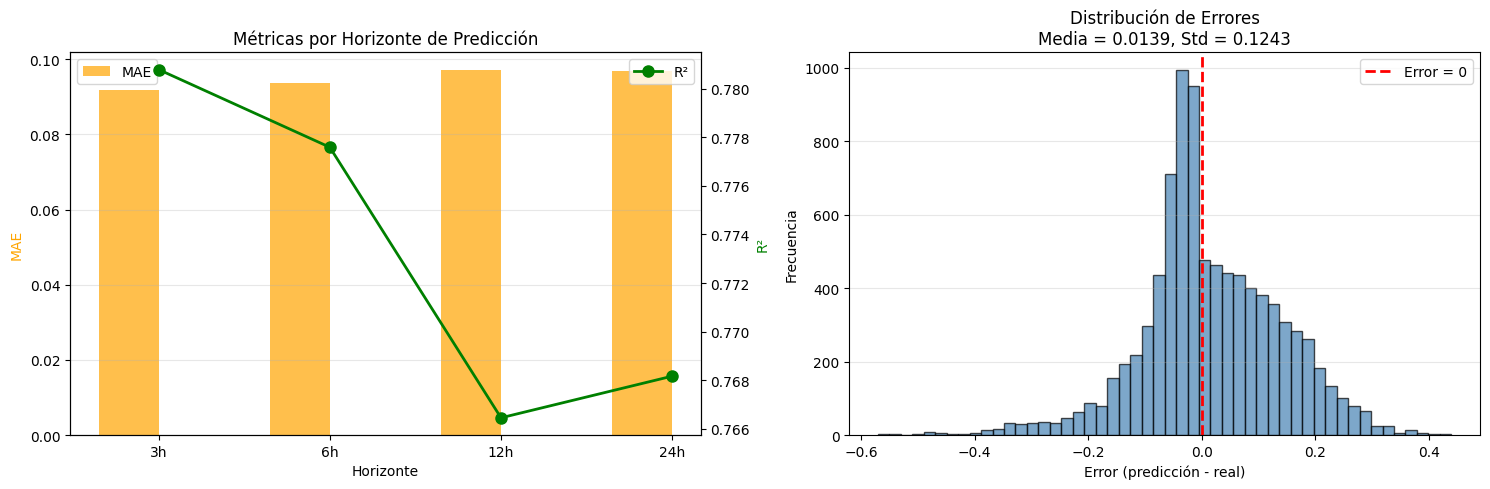

✅ Visualizaciones de evaluación completadas


In [114]:
# Visualización de predicciones vs valores reales
print("\n📊 Generando visualizaciones de predicciones...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Predicciones vs Valores Reales en Test Set', fontsize=14, fontweight='bold')

for i, h in enumerate(FORECAST_HORIZONS):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    y_true_h = y_test[:, i]
    y_pred_h = y_pred[:, i]
    
    # Scatter plot
    ax.scatter(y_true_h, y_pred_h, alpha=0.5, s=10)
    
    # Línea ideal (predicción perfecta)
    min_val = min(y_true_h.min(), y_pred_h.min())
    max_val = max(y_true_h.max(), y_pred_h.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción perfecta')
    
    # Métricas
    r2 = metricas_por_horizonte[h]['R2']
    mae = metricas_por_horizonte[h]['MAE']
    
    ax.set_xlabel('Valor Real (normalizado)')
    ax.set_ylabel('Predicción (normalizado)')
    ax.set_title(f'Horizonte: {h} horas\nR² = {r2:.3f}, MAE = {mae:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualización de errores por horizonte
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfica 1: Métricas por horizonte
horizontes_str = [f'{h}h' for h in FORECAST_HORIZONS]
maes = [metricas_por_horizonte[h]['MAE'] for h in FORECAST_HORIZONS]
r2s = [metricas_por_horizonte[h]['R2'] for h in FORECAST_HORIZONS]

x = np.arange(len(FORECAST_HORIZONS))
width = 0.35

axes[0].bar(x - width/2, maes, width, label='MAE', alpha=0.7, color='orange')
ax2 = axes[0].twinx()
ax2.plot(x, r2s, 'go-', linewidth=2, markersize=8, label='R²')
axes[0].set_xlabel('Horizonte')
axes[0].set_ylabel('MAE', color='orange')
ax2.set_ylabel('R²', color='green')
axes[0].set_title('Métricas por Horizonte de Predicción')
axes[0].set_xticks(x)
axes[0].set_xticklabels(horizontes_str)
axes[0].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[0].grid(True, alpha=0.3, axis='y')

# Gráfica 2: Distribución de errores
errores = y_pred.flatten() - y_test.flatten()
axes[1].hist(errores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes[1].set_xlabel('Error (predicción - real)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Errores\nMedia = {errores.mean():.4f}, Std = {errores.std():.4f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Visualizaciones de evaluación completadas")

---
## 📊 Resumen Final y Guía de Ajuste

### ✅ Proceso Completado

Has completado el entrenamiento fase por fase del modelo LSTM. Ahora tienes:

1. ✅ Dataset limpio y preprocesado
2. ✅ División train/validation/test (70%/15%/15%)
3. ✅ Secuencias temporales preparadas
4. ✅ Modelo LSTM entrenado
5. ✅ Métricas de evaluación por horizonte
6. ✅ Visualizaciones de rendimiento

### 🎯 ¿Cómo Interpretar los Resultados?

**Métricas Clave:**
- **R² (Coeficiente de Determinación)**: Mide qué tan bien el modelo explica la variabilidad
  - R² > 0.90: 🟢 Excelente
  - R² > 0.80: 🟡 Bueno
  - R² > 0.70: 🟠 Aceptable
  - R² < 0.70: 🔴 Necesita mejora

- **MAE (Mean Absolute Error)**: Error promedio en las predicciones
  - Más bajo = mejor
  - Se mide en las mismas unidades que el target (AQI normalizado)

- **RMSE (Root Mean Squared Error)**: Penaliza errores grandes
  - Más bajo = mejor
  - Útil para detectar predicciones muy desviadas

### 🔧 Guía de Ajuste según Resultados

#### Si el modelo tiene **Overfitting** (train loss << val loss):
```python
# Aumentar regularización
# Modificar en la celda de construcción del modelo:
- Aumentar Dropout: 0.2 → 0.3 o 0.4
- Reducir unidades LSTM: 128→64, 64→32, 32→16
- Agregar más datos de entrenamiento
```

#### Si el modelo tiene **Underfitting** (train loss y val loss altos):
```python
# Aumentar capacidad del modelo
- Aumentar unidades LSTM: 128→256, 64→128
- Agregar más capas LSTM
- Aumentar LOOKBACK: 24 → 48 horas
- Entrenar más épocas: EPOCHS = 150
```

#### Si las predicciones a **largo plazo** son malas:
```python
# Ajustar arquitectura para capturar patrones largos
- Usar LOOKBACK más largo: 48 o 72 horas
- Agregar capa de atención (Attention mechanism)
- Considerar modelo Transformer
```

#### Si el entrenamiento es **muy lento**:
```python
# Optimizar velocidad
- Aumentar BATCH_SIZE: 32 → 64 o 128
- Reducir datos de entrenamiento (usar más recientes)
- Usar GPU si está disponible
```

### 🚀 Próximos Pasos

1. **Analizar las métricas**: Revisa los valores de R², MAE por horizonte
2. **Ajustar hiperparámetros**: Según la guía de arriba
3. **Re-entrenar**: Ejecuta las celdas de nuevo con nuevos parámetros
4. **Comparar resultados**: Guarda las métricas de cada experimento
5. **Implementar en producción**: Cuando estés satisfecho con el rendimiento

In [99]:
# 📋 TABLA DE COMPARACIÓN DE EXPERIMENTOS
print("="*80)
print("📊 REGISTRO DE EXPERIMENTOS")
print("="*80)
print("\nUsa esta tabla para comparar diferentes configuraciones:\n")

# Crear tabla de experimentos (ejemplo)
experimentos = {
    'Experimento': ['Baseline'],
    'LOOKBACK': [LOOKBACK],
    'LSTM_units': ['128-64-32'],
    'Dropout': [0.2],
    'LR': [LEARNING_RATE],
    'Batch_size': [BATCH_SIZE],
    'R²_3h': [metricas_por_horizonte[3]['R2']],
    'R²_24h': [metricas_por_horizonte[24]['R2']],
    'MAE_prom': [mae_promedio],
    'Notas': ['Configuración inicial']
}

df_exp = pd.DataFrame(experimentos)
print(df_exp.to_string(index=False))

print("\n" + "="*80)
print("💡 TIPS PARA EXPERIMENTAR:")
print("="*80)
print("""
1. Cambia UN hiperparámetro a la vez
2. Guarda los resultados en la tabla de arriba
3. Compara R² y MAE entre experimentos
4. Mantén el mejor modelo (se guarda en 'mejor_modelo_lstm.keras')

Hiperparámetros principales:
  • LOOKBACK (celdas de configuración)
  • Unidades LSTM (celda de modelo)
  • DROPOUT (celda de modelo)
  • LEARNING_RATE (celda de configuración)
  • BATCH_SIZE (celda de configuración)
  • EPOCHS (celda de configuración)
""")

📊 REGISTRO DE EXPERIMENTOS

Usa esta tabla para comparar diferentes configuraciones:

Experimento  LOOKBACK LSTM_units  Dropout     LR  Batch_size    R²_3h  R²_24h  MAE_prom                 Notas
   Baseline        48  128-64-32      0.2 0.0009          32 0.785234 0.77467  0.090535 Configuración inicial

💡 TIPS PARA EXPERIMENTAR:

1. Cambia UN hiperparámetro a la vez
2. Guarda los resultados en la tabla de arriba
3. Compara R² y MAE entre experimentos
4. Mantén el mejor modelo (se guarda en 'mejor_modelo_lstm.keras')

Hiperparámetros principales:
  • LOOKBACK (celdas de configuración)
  • Unidades LSTM (celda de modelo)
  • DROPOUT (celda de modelo)
  • LEARNING_RATE (celda de configuración)
  • BATCH_SIZE (celda de configuración)
  • EPOCHS (celda de configuración)



---
## 🎉 ¡Sistema Completo!

### ✅ Todas las Fases Completadas

Has creado exitosamente un sistema de predicción de calidad del aire con:

**📦 Dataset:**
- Datos sintéticos realistas simulando TEMPO + OpenAQ
- División train/val/test: 70%/15%/15%
- Lookback: 24 horas
- Horizontes: 3, 6, 12, 24 horas

**🧠 Modelo:**
- LSTM Bidireccional (3 capas)
- Dropout para regularización
- Early stopping y reduce LR
- Optimizador: Adam

**📊 Validación:**
- Métricas por horizonte (R², MAE, RMSE)
- Curvas de aprendizaje
- Visualizaciones de predicciones vs reales

---

### 🔄 Proceso de Iteración

Para mejorar el modelo:

1. **Ejecuta todas las celdas** para obtener resultados baseline
2. **Modifica hiperparámetros** en las celdas de configuración
3. **Re-ejecuta desde la celda modificada** hacia abajo
4. **Compara métricas** con experimentos anteriores
5. **Repite** hasta obtener el rendimiento deseado

**Celdas clave para modificar:**
- **Celda 3**: Configuración (LOOKBACK, BATCH_SIZE, LEARNING_RATE, etc.)
- **Celda 11**: Arquitectura del modelo (unidades LSTM, Dropout)

---

### 📚 Referencias

- [LSTM Papers](https://www.tensorflow.org/tutorials/structured_data/time_series)
- [NASA TEMPO Mission](https://tempo.si.edu/)
- [OpenAQ API](https://openaq.org/)

¡Ahora puedes experimentar y ajustar el modelo según tus necesidades!

---
## 💾 **EXPORTACIÓN DEL MODELO**

Guardamos el modelo entrenado en diferentes formatos para su uso posterior.

In [117]:
import os
from datetime import datetime
import json

# Crear carpeta para modelos si no existe
MODELOS_DIR = "modelos_guardados"
os.makedirs(MODELOS_DIR, exist_ok=True)

# Nombre del modelo con timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
nombre_modelo = f"LSTM_Attention_AQI_{timestamp}"
ruta_base = os.path.join(MODELOS_DIR, nombre_modelo)

print("="*80)
print("💾 EXPORTANDO MODELO ENTRENADO")
print("="*80)
print(f"\n📁 Carpeta de destino: {MODELOS_DIR}/")
print(f"📝 Nombre del modelo: {nombre_modelo}")
print("-"*80)

# 1. Guardar modelo completo en formato Keras (.keras) - RECOMENDADO
ruta_keras = f"{ruta_base}.keras"
modelo.save(ruta_keras)
print(f"✅ Modelo Keras guardado: {ruta_keras}")
print(f"   → Incluye: arquitectura + pesos + optimizador + estado de entrenamiento")

# 2. Guardar solo los pesos (.weights.h5)
ruta_pesos = f"{ruta_base}.weights.h5"
modelo.save_weights(ruta_pesos)
print(f"✅ Pesos guardados: {ruta_pesos}")
print(f"   → Solo pesos, requiere reconstruir arquitectura para usar")

# 3. Guardar configuración del modelo (JSON)
config_modelo = {
    "arquitectura": modelo.get_config(),
    "input_shape": list(modelo.input_shape),
    "output_shape": list(modelo.output_shape),
    "total_params": modelo.count_params(),
    "tipo": "LSTM_Bidireccional_con_Attention"
}

ruta_config = f"{ruta_base}_config.json"
with open(ruta_config, 'w') as f:
    json.dump(config_modelo, f, indent=2)
print(f"✅ Configuración guardada: {ruta_config}")

# 4. Guardar metadatos del experimento
metadatos = {
    "nombre_experimento": nombre_exp,
    "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "metricas": {
        "val_loss": float(val_loss_actual),
        "r2_promedio": float(r2_promedio),
        "r2_3h": float(r2_3h),
        "r2_24h": float(r2_24h),
        "mae_promedio": float(mae_promedio)
    },
    "configuracion": {
        "LOOKBACK": LOOKBACK,
        "BATCH_SIZE": BATCH_SIZE,
        "LEARNING_RATE": LEARNING_RATE,
        "EPOCHS": EPOCHS,
        "PATIENCE_EARLY_STOP": PATIENCE_EARLY_STOP,
        "epocas_entrenadas": len(history.history['loss'])
    },
    "features": FEATURES,
    "target": TARGET,
    "horizones_prediccion": FORECAST_HORIZONS,
    "ubicacion": {
        "nombre": NOMBRE_UBICACION,
        "latitud": LATITUD,
        "longitud": LONGITUD
    },
    "notas": notas_exp
}

ruta_metadata = f"{ruta_base}_metadata.json"
with open(ruta_metadata, 'w') as f:
    json.dump(metadatos, f, indent=2)
print(f"✅ Metadatos guardados: {ruta_metadata}")

# 5. Guardar también el scaler para usar en producción
import pickle
ruta_scaler = f"{ruta_base}_scaler.pkl"
with open(ruta_scaler, 'wb') as f:
    pickle.dump(preparador.scaler, f)
print(f"✅ Scaler guardado: {ruta_scaler}")
print(f"   → Necesario para normalizar datos antes de predecir")

# 6. Guardar historial de entrenamiento
ruta_history = f"{ruta_base}_history.json"
history_dict = {
    "loss": [float(x) for x in history.history['loss']],
    "val_loss": [float(x) for x in history.history['val_loss']],
    "mae": [float(x) for x in history.history.get('mae', [])],
    "val_mae": [float(x) for x in history.history.get('val_mae', [])]
}
with open(ruta_history, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"✅ Historial de entrenamiento guardado: {ruta_history}")

print("\n" + "="*80)
print("✅ EXPORTACIÓN COMPLETADA")
print("="*80)
print(f"\n📦 Total de archivos guardados: 6")
print(f"📊 Tamaño total aproximado: {os.path.getsize(ruta_keras) / (1024*1024):.2f} MB")
print("\n💡 Para cargar el modelo:")
print(f"   from keras.models import load_model")
print(f"   modelo = load_model('{ruta_keras}')")
print("="*80)

💾 EXPORTANDO MODELO ENTRENADO

📁 Carpeta de destino: modelos_guardados/
📝 Nombre del modelo: LSTM_Attention_AQI_20251004_002409
--------------------------------------------------------------------------------
✅ Modelo Keras guardado: modelos_guardados\LSTM_Attention_AQI_20251004_002409.keras
   → Incluye: arquitectura + pesos + optimizador + estado de entrenamiento
✅ Pesos guardados: modelos_guardados\LSTM_Attention_AQI_20251004_002409.weights.h5
   → Solo pesos, requiere reconstruir arquitectura para usar
✅ Configuración guardada: modelos_guardados\LSTM_Attention_AQI_20251004_002409_config.json
✅ Metadatos guardados: modelos_guardados\LSTM_Attention_AQI_20251004_002409_metadata.json
✅ Scaler guardado: modelos_guardados\LSTM_Attention_AQI_20251004_002409_scaler.pkl
   → Necesario para normalizar datos antes de predecir
✅ Historial de entrenamiento guardado: modelos_guardados\LSTM_Attention_AQI_20251004_002409_history.json

✅ EXPORTACIÓN COMPLETADA

📦 Total de archivos guardados: 6
📊 Ta

In [118]:
# Crear script de ejemplo para usar el modelo en producción
script_uso = f'''"""
Script de ejemplo para usar el modelo LSTM con Attention entrenado
Modelo: {nombre_modelo}
Fecha de entrenamiento: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
"""

import numpy as np
import pickle
from keras.models import load_model

# 1. Cargar el modelo
print("Cargando modelo...")
modelo = load_model("{ruta_keras}")

# 2. Cargar el scaler
print("Cargando scaler...")
with open("{ruta_scaler}", "rb") as f:
    scaler = pickle.load(f)

# 3. Preparar datos de entrada
# Los datos deben tener forma: (n_muestras, {LOOKBACK}, {len(FEATURES)})
# Features esperados: {FEATURES}

def predecir_aqi(datos_historicos):
    """
    Predice AQI para los siguientes horizontes: {FORECAST_HORIZONS}
    
    Args:
        datos_historicos: DataFrame o array con las últimas {LOOKBACK} horas
                         Columnas: {FEATURES}
    
    Returns:
        predicciones: Array con 4 valores (AQI a 3h, 6h, 12h, 24h)
    """
    # Normalizar datos
    datos_norm = scaler.transform(datos_historicos)
    
    # Reshape para el modelo (agregar dimensión batch)
    datos_input = datos_norm.reshape(1, {LOOKBACK}, {len(FEATURES)})
    
    # Realizar predicción
    prediccion = modelo.predict(datos_input, verbose=0)
    
    # Desnormalizar (asumiendo que AQI es la columna 0)
    # Nota: Ajustar índice según tu configuración de scaler
    prediccion_real = scaler.inverse_transform(
        np.column_stack([prediccion[0], np.zeros((4, {len(FEATURES)-1}))])
    )[:, 0]
    
    return prediccion_real

# Ejemplo de uso:
# datos = pd.DataFrame(...)  # Últimas {LOOKBACK} horas de datos
# predicciones = predecir_aqi(datos)
# print(f"AQI predicho a 3h: {{predicciones[0]:.2f}}")
# print(f"AQI predicto a 6h: {{predicciones[1]:.2f}}")
# print(f"AQI predicho a 12h: {{predicciones[2]:.2f}}")
# print(f"AQI predicho a 24h: {{predicciones[3]:.2f}}")
'''

# Guardar script de ejemplo
ruta_script = f"{ruta_base}_uso_ejemplo.py"
with open(ruta_script, 'w', encoding='utf-8') as f:
    f.write(script_uso)

print("\n" + "="*80)
print("📝 SCRIPT DE EJEMPLO CREADO")
print("="*80)
print(f"✅ Archivo: {ruta_script}")
print("\n💡 Este script muestra cómo:")
print("   • Cargar el modelo guardado")
print("   • Cargar el scaler para normalización")
print("   • Preparar datos de entrada")
print("   • Realizar predicciones")
print("   • Desnormalizar resultados")
print("="*80)


📝 SCRIPT DE EJEMPLO CREADO
✅ Archivo: modelos_guardados\LSTM_Attention_AQI_20251004_002409_uso_ejemplo.py

💡 Este script muestra cómo:
   • Cargar el modelo guardado
   • Cargar el scaler para normalización
   • Preparar datos de entrada
   • Realizar predicciones
   • Desnormalizar resultados


In [119]:
# Verificar archivos guardados
print("\n" + "="*80)
print("📂 VERIFICACIÓN DE ARCHIVOS EXPORTADOS")
print("="*80)

import glob
archivos = glob.glob(f"{MODELOS_DIR}/{nombre_modelo}*")
archivos.sort()

print(f"\n📁 Carpeta: {MODELOS_DIR}/")
print(f"📦 Total de archivos: {len(archivos)}\n")

for archivo in archivos:
    tamaño = os.path.getsize(archivo)
    if tamaño > 1024*1024:
        tamaño_str = f"{tamaño/(1024*1024):.2f} MB"
    elif tamaño > 1024:
        tamaño_str = f"{tamaño/1024:.2f} KB"
    else:
        tamaño_str = f"{tamaño} bytes"
    
    extension = os.path.splitext(archivo)[1]
    iconos = {
        '.keras': '🧠',
        '.h5': '⚖️',
        '.json': '📄',
        '.pkl': '🔧',
        '.py': '🐍'
    }
    icono = iconos.get(extension, '📁')
    
    print(f"{icono} {os.path.basename(archivo):60s} ({tamaño_str:>10s})")

print("\n" + "="*80)
print("✅ TODOS LOS ARCHIVOS VERIFICADOS")
print("="*80)

# Mostrar resumen de uso
print("\n📚 GUÍA RÁPIDA DE USO:")
print("-"*80)
print(f"1️⃣  Para cargar el modelo completo:")
print(f"    from keras.models import load_model")
print(f"    modelo = load_model('{ruta_keras}')")
print()
print(f"2️⃣  Para cargar solo los pesos en una arquitectura:")
print(f"    modelo = crear_modelo_lstm_con_attention(...)")
print(f"    modelo.load_weights('{ruta_pesos}')")
print()
print(f"3️⃣  Para usar el scaler:")
print(f"    import pickle")
print(f"    with open('{ruta_scaler}', 'rb') as f:")
print(f"        scaler = pickle.load(f)")
print()
print(f"4️⃣  Ver script de ejemplo completo:")
print(f"    {ruta_script}")
print("="*80)


📂 VERIFICACIÓN DE ARCHIVOS EXPORTADOS

📁 Carpeta: modelos_guardados/
📦 Total de archivos: 7

🧠 LSTM_Attention_AQI_20251004_002409.keras                     (   2.86 MB)
⚖️ LSTM_Attention_AQI_20251004_002409.weights.h5                (   2.84 MB)
📄 LSTM_Attention_AQI_20251004_002409_config.json               (  32.52 KB)
📄 LSTM_Attention_AQI_20251004_002409_history.json              (   8.50 KB)
📄 LSTM_Attention_AQI_20251004_002409_metadata.json             ( 833 bytes)
🔧 LSTM_Attention_AQI_20251004_002409_scaler.pkl                ( 802 bytes)
🐍 LSTM_Attention_AQI_20251004_002409_uso_ejemplo.py            (   1.97 KB)

✅ TODOS LOS ARCHIVOS VERIFICADOS

📚 GUÍA RÁPIDA DE USO:
--------------------------------------------------------------------------------
1️⃣  Para cargar el modelo completo:
    from keras.models import load_model
    modelo = load_model('modelos_guardados\LSTM_Attention_AQI_20251004_002409.keras')

2️⃣  Para cargar solo los pesos en una arquitectura:
    modelo = crear